##IST 664: Final Project
##News Summarization
####Name: Nimisha Kadam
Assertion statement: “I wrote all of the explanatory text and comments in this notebook. The was adapted from https://github.com/Moeinh77/Transformer-networks-for-abstractive-summarization/blob/master/main-github.ipynb"

####Introduction:

This is a project based on News summarization using Abstractive summarization techniques and Transformer networks. In this project, instead of summarizing texts based on the important features I have summarized based on the main idea of the text which is also known as Abstractive summarization. 
The source of dataset is Kaggle, https://www.kaggle.com/shashichander009/inshorts-news-data. This dataset consists of Inshort news data, having long reviews of news as well as the summary or short reviews of the news. The dataset included 55k records of news and their summaries. More huge datasets can be used for model improvisation and generalization.
Preprocessing is computed using the preprocessing library of keras, computed tokenization and performed cleaning using RegEx.
Usually, RNN are used for sequence-to-sequence models but few years ago Transformer Neural Networks was introduced with the multi-head attention technique. This model tracks the relationships between the words in data and thus derives the meaning or the main idea of the text. In this project, I have implemented a Transformer Neural Network to summarize data. 
Multi-Head Attention layer: In this module, the model runs through an attention mechanism several times in parallel and later linearly concatenated the results. Because of this, several aspects in a sequence can be paid attention to and produce better results.
In the encoder model, there is a multi-head attention layer followed by a feed-forward. The encoder output is then fed into the decoder model followed by two multi-head attention layers, one using a padding mask and other using a look ahead mask which is a mask created for the future words predicting the current words. The two multi-head attention layers are then followed by the feed-forward network layer. After each multi-head attention layer and feed-forward network layers there are dropout layers and normalization layers added. The final layer consists of a Softmax layer and the output in then linearized and provides output.  



In [64]:
import re
import os
import time
import numpy as np
import pandas as pd 
import unicodedata
import tensorflow as tf
import tensorflow as tf
from tensorflow import keras
from keras.layers import Embedding
from keras.losses import SparseCategoricalCrossentropy, CategoricalCrossentropy
from keras.preprocessing.text import Tokenizer 
from keras.callbacks import LearningRateScheduler
import csv
#defining the parameters that will be used further in the model
BUFFER_SIZE = 20000
BATCH_SIZE = 64
embedding_dim = 50

In [65]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Reading the data and droppping useless columns

In [66]:
#reading the excel file from drive and displaying few contents
data_unprocessed_news = pd.read_excel('/content/drive/MyDrive/Inshorts Cleaned Data.xlsx')
data_unprocessed_news.head()

,short,long,Source,Time,Publish Date
0,4 ex-bank officials booked for cheating bank o...,The CBI on Saturday booked four former officia...,The New Indian Express,09:25:00,2017-03-26
1,Supreme Court to go paperless in 6 months: CJI,Chief Justice JS Khehar has said the Supreme C...,Outlook,22:18:00,2017-03-25
2,"At least 3 killed, 30 injured in blast in Sylh...","At least three people were killed, including a...",Hindustan Times,23:39:00,2017-03-25
3,Why has Reliance been barred from trading in f...,Mukesh Ambani-led Reliance Industries (RIL) wa...,Livemint,23:08:00,2017-03-25
4,Was stopped from entering my own studio at Tim...,TV news anchor Arnab Goswami has said he was t...,YouTube,23:24:00,2017-03-25


In [67]:
from sklearn.utils import shuffle
# shuffling the records in the data 
data_unprocessed_news = shuffle(data_unprocessed_news)
data_unprocessed_news.head()

,short,long,Source,Time,Publish Date
6619,Fashion rental startup Flyrobe rents $1mn wort...,"Flyrobe, a 15-month old fashion rental startup...",Flyrobe,14:52:00,2017-02-10
26796,IAS officer transferred over post on Deendayal...,The BJP government in Chhattisgarh on Saturday...,PTI,12:15:00,2016-10-09
35437,UN calls for Syria ceasefire to repair water w...,The United Nations has called for a ceasefire ...,Reuters,09:34:00,2016-08-10
38333,Model who posed semi-nude for Modi joins NCP,"Model Meghna Patel, who had posed semi-nude wi...",The Financial Express,09:37:00,2016-08-02
10649,World&#39;s eight richest people have same wea...,The world&#39;s eight richest people together ...,The Guardian,12:48:00,2017-01-16


In [68]:
#creating two dataframes, one consisting of the long reviews and another one consisting of the summary
summaries, longreview = pd.DataFrame(), pd.DataFrame()
summaries['short'] = data_unprocessed_news['short']
longreview['long'] = data_unprocessed_news['long']
(summaries.shape,longreview.shape) #we have total of 55k records

((55104, 1), (55104, 1))

### Cleaning the data for training

In [69]:
#cleaning the data using regex
#replacing the abbreviations such as "you've" with "you have" and many more such abbreviations and also converting characters to lower case
def clean_words(sentence):
    sentence = str(sentence).lower()
    sentence = unicodedata.normalize('NFKD', sentence).encode('ascii', 'ignore').decode('utf-8', 'ignore') #for converting é to e and other accented chars
    sentence = re.sub(r"http\S+","",sentence)
    sentence = re.sub(r"there's", "there is", sentence)
    sentence = re.sub(r"i'm", "i am", sentence)
    sentence = re.sub(r"he's", "he is", sentence)
    sentence = re.sub(r"she's", "she is", sentence)
    sentence = re.sub(r"it's", "it is", sentence)
    sentence = re.sub(r"that's", "that is", sentence)
    sentence = re.sub(r"what's", "that is", sentence)
    sentence = re.sub(r"where's", "where is", sentence)
    sentence = re.sub(r"how's", "how is", sentence)
    sentence = re.sub(r"\'ll", " will", sentence)
    sentence = re.sub(r"\'ve", " have", sentence)
    sentence = re.sub(r"\'re", " are", sentence)
    sentence = re.sub(r"\'d", " would", sentence)
    sentence = re.sub(r"\'re", " are", sentence)
    sentence = re.sub(r"won't", "will not", sentence)
    sentence = re.sub(r"can't", "cannot", sentence)
    sentence = re.sub(r"n't", " not", sentence)
    sentence = re.sub(r"n'", "ng", sentence)
    sentence = re.sub(r"'bout", "about", sentence)
    sentence = re.sub(r"'til", "until", sentence)
    sentence = re.sub(r"\"", "", sentence)
    sentence = re.sub(r"\'", "", sentence)
    sentence = re.sub(r' s ', "",sentence)
    sentence = re.sub(r"&39", "", sentence) # the inshorts data has this in it
    sentence = re.sub(r"&34", "", sentence) # the inshorts data has this in it
    sentence = re.sub(r"[\[\]\\0-9()\"$#%/@;:<>{}`+=~|.!?,-]", "", sentence)
    sentence = re.sub(r"&", "", sentence)
    sentence = re.sub(r"\\n", "", sentence)
    sentence = sentence.strip()
    return sentence

In [70]:
#applying the above function to the two dataframes created earlier for the long reviews and the summaries
summaries['short'] = summaries['short'].apply(lambda x: clean_words(x))
longreview['long'] = longreview['long'].apply(lambda x: clean_words(x))

In [71]:
longreview.head()#displaying the contents to observe the cleaned data

,long
6619,flyrobe a month old fashion rental startup wit...
26796,the bjp government in chhattisgarh on saturday...
35437,the united nations has called for a ceasefire ...
38333,model meghna patel who had posed seminude with...
10649,the worlds eight richest people together own a...


In [72]:
#defining the starting and ending of the summary records by adding "<startseq>" at the start and "<endseq>" at the end 
start_token, end_token = '<startseq>' , '<endseq>'
summaries = summaries.apply(lambda x: start_token + ' ' + x + ' ' + end_token)
summaries.head()

,short
6619,<startseq> fashion rental startup flyrobe rent...
26796,<startseq> ias officer transferred over post o...
35437,<startseq> un calls for syria ceasefire to rep...
38333,<startseq> model who posed seminude for modi j...
10649,<startseq> worlds eight richest people have sa...


In [73]:
val_split = 0.1
#splitting the data into training set and validation set for both dataframes
summaries_train = summaries[int(len(summaries)*val_split):]
summaries_val = summaries[:int(len(summaries)*val_split)]
longreview_train = longreview[int(len(summaries)*val_split):]
longreview_val = longreview[:int(len(summaries)*val_split)]

len(longreview_val),len(longreview_train)

(5510, 49594)

In [74]:
longreview_train.iloc[0], summaries_train.iloc[0] #displaying the long review and the summary for first record

(long    ford motor company founder henry ford who was ...
 Name: 38637, dtype: object,
 short    <startseq> ford was inspired by thomas edison ...
 Name: 38637, dtype: object)

finding the maximum length of questions and answers

In [75]:
#since the data is unbalanced we have a lot of sentences which are abnormally long
#hence we are considering the maximum length based on distribution of 95% interval 
def max_length(shorts, longs, prct):
    #creating a list for captions in the sentences

    length_longs = list(len(d.split()) for d in longs)
    length_shorts = list(len(d.split()) for d in shorts)

    print('percentile {} of length of news: {}'.format(prct,np.percentile(length_longs, prct))) #calculating the percentile of the lengths of the sentences
    print('longest sentence: ', max(length_longs)) #displaying the maximum length of the sentence
    print()
    print('percentile {} of length of summaries: {}'.format(prct,np.percentile(length_shorts, prct)))#calculating the percentile of the lengths of the sentences
    print('longest sentence: ', max(length_shorts)) #displaying the maximum length of the sentence
    print()
    return int(np.percentile(length_longs, prct)),int(np.percentile(length_shorts, prct))

# considering the length of the news and summaries to be based on which fits into the range of the percentile of the data
max_len_news, max_len_summary= max_length(summaries_train['short'].to_list(), longreview_train['long'].to_list(), 90)

print('max-length longreview chosen for training: ', max_len_news)
print('max-length summaries chosen for training: ', max_len_summary)

percentile 90 of length of news: 60.0
longest sentence:  66

percentile 90 of length of summaries: 12.0
longest sentence:  16

max-length longreview chosen for training:  60
max-length summaries chosen for training:  12


### Dataset prepration


In [76]:
# creating a list of vocab words from the summaries 
def create_vocab(shorts, longs = None, minimum_repeat = 3):

    # Create a list of all the captions
    all_captions = []
    for s in shorts:
        all_captions.append(s)

    #unique words based on the minimum repeat times of those words in corpus are considered
    word_counts = {}
    nsents = 0
    for sent in all_captions:
        nsents += 1
        for w in sent.split(' '):
            word_counts[w] = word_counts.get(w, 0) + 1 #getting those words only who are not there already in the list

    vocab = [w for w in word_counts if word_counts[w] >= minimum_repeat] 
    #getting only those words in the vocabulary who have occurred atleast the minimum times measure mentioned in the parameters
    
    vocab = list(set(vocab))
    return vocab

In [77]:
#preparing decoder vocab list
#every words should have been occured atleast for the minimum_repeat times 
#mentioned in the parameters
vocab_dec = create_vocab(summaries_train['short'].to_list(), minimum_repeat=5) 
#using the words occured in summaries dataframe only

#discarding single character words from the vocab except "a" and "i"
for v in vocab_dec:
    if len(v) == 1 and v!='a' and v!='i':
        vocab_dec.remove(v) 
        
vocab_dec = sorted(vocab_dec)[1:] #[1:] is for the '' 
vocab_dec[:10]

['<endseq>',
 '<startseq>',
 'a',
 'aa',
 'aadhaar',
 'aadhaarbased',
 'aadmi',
 'aam',
 'aamir',
 'aamirs']

In [78]:
#here we are computing the encoder vocab list and have changed the minimum_repeat 
#times from 5 to 3 and performed the same analysis done above 
vocab_enc = create_vocab(longreview_train['long'].to_list(), minimum_repeat=3)

for v in vocab_enc:
  #discarding single character words from the vocab except "a" and "i"
    if len(v) == 1 and v!='a' and v!='i':
        vocab_enc.remove(v) 
        
vocab_enc = sorted(vocab_enc)[1:] #[1:] is for the '' 
vocab_enc[:10]

['****ing',
 'a',
 'a**holes',
 'aa',
 'aaa',
 'aadat',
 'aadhaar',
 'aadhaarbased',
 'aadhaarenabled',
 'aadhar']

## Out of Vocab tokens (oov_token)
We can define an Out Of Vocab token in Keras, which will replace any new words with a token of our choice. This is preferable to simply discarding unknown terms because it notifies our model that it represented some information.

In [79]:
oov_token = '<UNK>'
filters = '!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n' 
#filtering out all the non-digit data again just for sureity 

#using thetokeninzer in the keras libray of preprocessing tools
#filtering out all the non-digit data and also replacing out of vocab words 
#with a token defined by us earlier "<UNK>"
document_tokenizer = keras.preprocessing.text.Tokenizer(filters = filters,oov_token=oov_token)
summary_tokenizer = keras.preprocessing.text.Tokenizer(filters = filters,oov_token=oov_token)
document_tokenizer.fit_on_texts(vocab_enc)
summary_tokenizer.fit_on_texts(vocab_dec)#summaries_train['short'])

# Calculating number of words in the decoder and encoder vocabulary for further use
encoder_vocab_size = len(document_tokenizer.word_index) + 1 
decoder_vocab_size = len(summary_tokenizer.word_index) + 1

#displaying the vocab size
encoder_vocab_size, decoder_vocab_size

(32455, 8919)

In [80]:
ixtoword_enc = {} #defining a index to word dictionary
ixtoword_dec = {} #defining a index to word dictionary

wordtoix_enc = document_tokenizer.word_index #defining a word to index dictionary
ixtoword_enc[0] = '<PAD0>' #padding is indicated with 0, vocab does not have words with index 0
ixtoword_dec[0] = '<PAD0>' #padding is indicated with 0, vocab does not have words with index 0

for w in document_tokenizer.word_index:
    ixtoword_enc[document_tokenizer.word_index[w]] = w

wordtoix_dec = summary_tokenizer.word_index # word to index dictionary

for w in summary_tokenizer.word_index:
    ixtoword_dec[summary_tokenizer.word_index[w]] = w

In [81]:
#assigning index number for each word to map it in the embedding words list
inputs = document_tokenizer.texts_to_sequences(longreview_train['long'])
targets = summary_tokenizer.texts_to_sequences(summaries_train['short'])
inputs_val = document_tokenizer.texts_to_sequences(longreview_val['long'])
targets_val = summary_tokenizer.texts_to_sequences(summaries_val['short'])

In [82]:
#converting the sequence length to the desired length
#padding is added to shorter sentences 
#sentences are truncated whose lengths are longer than the max_lengths mentioned
inputs = keras.preprocessing.sequence.pad_sequences(inputs, maxlen=max_len_news, padding='post', truncating='post')
targets = keras.preprocessing.sequence.pad_sequences(targets, maxlen=max_len_summary, padding='post', truncating='post')
inputs_val = keras.preprocessing.sequence.pad_sequences(inputs_val, maxlen=max_len_news, padding='post', truncating='post')
targets_val = keras.preprocessing.sequence.pad_sequences(targets_val, maxlen=max_len_summary, padding='post', truncating='post')

In [83]:
# validating the split of training data
dataset = tf.data.Dataset.from_tensor_slices((inputs,targets)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset_val = tf.data.Dataset.from_tensor_slices((inputs_val,targets_val)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE*2)

In [84]:
#resetting the index of long reviews and summary dataframes to the original ones
longreview_val.reset_index(inplace=True, drop=True)
summaries_val.reset_index(inplace=True, drop=True)
longreview_train.reset_index(inplace=True, drop=True)
summaries_train.reset_index(inplace=True, drop=True)

### Defining the model

In [85]:
import matplotlib.pyplot as plt

#defining a function to plot a graph of loss and validations for each epochs training model
def hist(history):
    plt.title('Loss')

    x= [i[0] for i in history['val']]
    y=[i[1] for i in history['val']]
    plt.plot(x,y,'x-')
    
    x= [i[0] for i in history['train']]
    y=[i[1] for i in history['train']]    
    plt.plot(x,y,'o-')

    plt.legend(['validation','train'])
    plt.show()
    print('smallest val loss:', sorted(history['val'],key=lambda x: x[1])[0])

#### Scaled Dot Product
Scaled dot-product attention is an attention mechanism where the dot products are scaled down by sqrt(dk). Formally we have a query, a key and a value  and calculate the attention as:

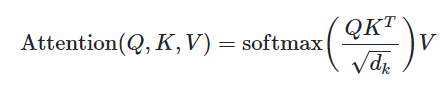

We are computing the encoder-decoder modelling using attention since it obtains the significance in a sequence to sequence model

In [86]:
#here we have calculated scaled dot product for attention
def scaled_dot_product_attention(q, k, v, mask):
    matmul_qk = tf.matmul(q, k, transpose_b=True)
    #computed matrix multiplication between querry, key and transposing the matrix

    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)
    #executing the above mentioned formula

    if mask is not None:
        scaled_attention_logits += (mask * -1e9)  

    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)
    #adding a softmax layer in the attention computation

    output = tf.matmul(attention_weights, v) 
    #computing a matrix multiplication between derived attention weights and value
    return output, attention_weights

#### Multi-headed attention
Multi-head Attention is an attention mechanism module that goes through an attention mechanism repeatedly in parallel. After that, the independent attention outputs are combined and linearly converted into the projected dimension.

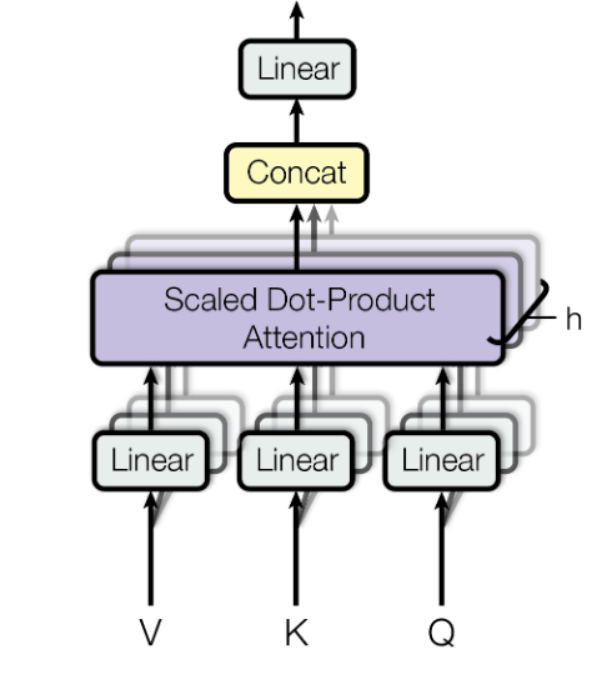

In [87]:
#defining a class for multi-head attention and mentioning all the dense layers
class MultiHeadAttention(keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads 
        #dimensions of Q, K, V are called depth

        #same input is provided for all the three layers i.e. X
        self.wq = keras.layers.Dense(d_model,kernel_regularizer=keras.regularizers.l2(l=lmbda_l2))
        #computing layer for querry
        self.wk = keras.layers.Dense(d_model,kernel_regularizer=keras.regularizers.l2(l=lmbda_l2))
        #computing layer for key
        self.wv = keras.layers.Dense(d_model,kernel_regularizer=keras.regularizers.l2(l=lmbda_l2))
        #computing layer for value

        self.dense = tf.keras.layers.Dense(d_model,kernel_regularizer=keras.regularizers.l2(l=lmbda_l2))
    
    #reshaping the querry, key, value matrices 
    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])
    
    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]
        
        #the layers' weights are fed to the q, k, v matrices
        q = self.wq(q)
        k = self.wk(k)
        v = self.wv(v)
        
        # reshaping the matrices again
        q = self.split_heads(q, batch_size)
        k = self.split_heads(k, batch_size)
        v = self.split_heads(v, batch_size)

        #using the scaled_dot_product function created in the earlier snippet
        scaled_attention, attention_weights = scaled_dot_product_attention(
            q, k, v, mask)

        #trnasposing the scaled attention matrix
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])
        
        #the self dense layer requires only one output layer hence we are concating
        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))
        output = self.dense(concat_attention)
            
        return output, attention_weights

#### Positional Encoding
As the sentences are fed into the transformer model, the model does not have any sense about the position or the order of the words. But nonetheless we require that information and hence we are performing positional encoding in order to state the "piece of information" about the word's position/order.

In [88]:
#defining a function to perform positional encoding for a given model
def get_angles(position, i, d_model):
  #computing a set of angel rates based on the model
    angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
    return position * angle_rates

# The dimension of positional encodings is the same as
# the embeddings (d_model) for facilitating the summation of both.
def positional_encoding(position, d_model):
    angle_rads = get_angles(
        np.arange(position)[:, np.newaxis],
        np.arange(d_model)[np.newaxis, :],
        d_model
    )

    # applying sine transformation to even indexes in the array; 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

    # applying cosine transformation to odd indexes in the array; 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

    pos_encoding = angle_rads[np.newaxis, ...]

    return tf.cast(pos_encoding, dtype=tf.float32)

#### Layers

#### Embeddings preparation

In [89]:
#Creating an embedding matrix based on the vocab length, word to index dictionary 
#and the embedding file extracted from github
def make_embedding_layer(vocab_len, wordtoix, embedding_dim=200, glove=True):
    if glove == False:
        print('Just a zero matrix loaded')
        embedding_matrix = np.zeros((vocab_len, embedding_dim)) 
        #just a zero matrix 
    else:
        print('Loading glove...')
        embeddings_index = {} 
        #creating a dictionary to store the words as values and their coefficients are stored in key
        with open('/content/drive/MyDrive/glove.6B.50d.txt', 'r') as f:
          for line in f:
            values = line.split() #splitting the data
            word = values[0] #saving the word in the list
            coefs = np.asarray(values[1:], dtype='float32') #saving their coefficients
            embeddings_index[word] = coefs #inserting the words and their coefficients into the dictionary
        f.close()
        # Getting a n-dim dense vector for every vocab_rocc
        embedding_matrix = np.zeros((vocab_len, embedding_dim)) 
        #importing weights for the embedding layers of keras
        for word, i in wordtoix.items():
            embedding_vector = embeddings_index.get(word)
            if embedding_vector is not None:
                # Words not present in the embedding index dict will be zero
                embedding_matrix[i] = embedding_vector
        
        print("GloVe ",embedding_dim, ' loaded!')

    embedding_layer = Embedding(vocab_len, embedding_dim, mask_zero=True, trainable=False) 
    #because of the limited vocab we are using 0 as padding 
    #hence mask_zero = true
    embedding_layer.build((None,))
    embedding_layer.set_weights([embedding_matrix])
    return embedding_layer

#creating embedding for the encoder model
embeddings_encoder = make_embedding_layer(encoder_vocab_size, wordtoix_enc, embedding_dim=embedding_dim, glove=True)
#creating embeddings for the decoder model
embeddings_decoder = make_embedding_layer(decoder_vocab_size, wordtoix_dec, embedding_dim=embedding_dim, glove=True)


Loading glove...
GloVe  50  loaded!
Loading glove...
GloVe  50  loaded!


#### Transformer layers



In [90]:
#defining the hyper parameters that will be used ahead
init_lr = 1e-3
lmbda_l2 = 0.1
d_out_rate = 0.1 #tested 0.4, 0.3, 0.1 values, 0.1 seems to be the best
num_layers = 4 #changed from 4 to 5 to learn better
d_model = embedding_dim #d_model is the representation dimension or embedding dimension of a word (usually in the range 128–512)
dff = 512 #number of neurons in feed forward network
num_heads = 5 #first it was 8, later changed it to 10 to use embd =300d

In [91]:
# The Point-wise feed-forward network block is a two-layer 
#linear transformation used identically throughout the model
def point_wise_feed_forward_network(d_model, dff):
    return keras.Sequential([
        keras.layers.Dense(dff, activation='relu',kernel_regularizer=keras.regularizers.l2(l=lmbda_l2)),
        keras.layers.Dense(d_model,kernel_regularizer=keras.regularizers.l2(l=lmbda_l2))
    ]) #defining dense layers for the feed forward network

In [92]:
#defining a class for the layers in the encoder model
class EncoderLayer(keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=d_out_rate):
        super(EncoderLayer, self).__init__()
        
        #defining the multi-head attention layer in the model
        self.mha = MultiHeadAttention(d_model, num_heads)
        #defining the feed forward network layer in the model
        self.ffn = point_wise_feed_forward_network(d_model, dff)

        #defining the two normalization layers that are suppose to be added 
        #between the main layers of the model
        self.layernorm1 = keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = keras.layers.LayerNormalization(epsilon=1e-6)
        
        #defining the drop out layer which is to be added before normalization
        self.dropout1 = keras.layers.Dropout(rate)
        self.dropout2 = keras.layers.Dropout(rate)
   
    #this model has one layer of multi-head attention
    def call(self, x, training, mask):
      #adding multi-head attention layer, dropout layer and then the normalization layer
        attn_output, _ = self.mha(x, x, x, mask)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)

      #adding the feed forward network layer, dropout layer and then the normalization layer
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        #computing all the outputs together to return
        out2 = self.layernorm2(out1 + ffn_output)

        return out2

In [93]:
#defining a class for the layers in the decoder model
class DecoderLayer(keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=d_out_rate):
        super(DecoderLayer, self).__init__()

        #defining the multi-head attention layer in the model
        self.mha1 = MultiHeadAttention(d_model, num_heads)
        #defining another multi-head attention layer which will be masked
        self.mha2 = MultiHeadAttention(d_model, num_heads)

        #defining the feed forward network layer in the model
        self.ffn = point_wise_feed_forward_network(d_model, dff)

        #defining the three normalization layers that are suppose to be added 
        #between the main layers of the model
        self.layernorm1 = keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = keras.layers.LayerNormalization(epsilon=1e-6)

        #defining the drop out layer which is to be added before normalization
        self.dropout1 = keras.layers.Dropout(rate)
        self.dropout2 = keras.layers.Dropout(rate)
        self.dropout3 = keras.layers.Dropout(rate)
    
    #decoder model has two multi-head attention layers, one is masked another is unmasked
    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
      #adding multi-head attention layer with look ahead mask, dropout layer and then the normalization layer
        attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)
        attn1 = self.dropout1(attn1, training=training)
        out1 = self.layernorm1(attn1 + x)

      #adding multi-head attention layer with padding mask, dropout layer and then the normalization layer
        attn2, attn_weights_block2 = self.mha2(enc_output, enc_output, out1, padding_mask)
        attn2 = self.dropout2(attn2, training=training)
        out2 = self.layernorm2(attn2 + out1)

      #adding the feed forward network layer, dropout layer and then the normalization layer
        ffn_output = self.ffn(out2)
        ffn_output = self.dropout3(ffn_output, training=training)
        #computing all the outputs together to return
        out3 = self.layernorm3(ffn_output + out2)

        return out3, attn_weights_block1, attn_weights_block2

In [94]:
#defining a class for the encoder model
class Encoder(keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, maximum_position_encoding, rate=d_out_rate):
        super(Encoder, self).__init__()

        #initializing all the parameters and the layers to be added in the model
        self.d_model = d_model
        self.num_layers = num_layers

        #initializing the embeddings encoder model and the postional encodding computed earlier
        self.embedding = embeddings_encoder
        self.pos_encoding = positional_encoding(maximum_position_encoding, self.d_model)

        #intizlizing the encoder layers computed in the above snippet
        self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]

        #intializing the dropout layers
        self.dropout = keras.layers.Dropout(rate)
        self.dropout_embd = keras.layers.Dropout(rate)
        
    def call(self, x, training, mask):
        seq_len = tf.shape(x)[1]

        #Firstly adding the embeddings vector later the positional encoding
        x = self.embedding(x)
        x = self.dropout_embd(x, training=training) 
        #dropout added to encoder input changed from nothing to this
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)

        #adding the encoder layers to the model
        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training, mask)
    
        return x

In [95]:
#defining a class for the decoder model
class Decoder(keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size, maximum_position_encoding, rate=d_out_rate):
        super(Decoder, self).__init__()

        #initializing all the parameters and the layers to be added in the model
        self.d_model = d_model
        self.num_layers = num_layers

        #initializing the embeddings encoder model and the postional encodding computed earlier
        self.embedding = embeddings_decoder
        self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)

        #intizlizing the decoder layers computed in the above snippet
        self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)] # a list of decoder layers
        
        #intializing the dropout layers
        self.dropout = keras.layers.Dropout(rate)
    
    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        seq_len = tf.shape(x)[1]
        attention_weights = {}

        #Firstly adding the embeddings vector later the positional encoding
        x = self.embedding(x)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
          #adding the decoder layers to the final model
            x, block1, block2 = self.dec_layers[i](x, enc_output, training, look_ahead_mask, padding_mask) 
            # output from the encoder is fed into the decoder model
            attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
            attention_weights['decoder_layer{}_block2'.format(i+1)] = block2
    
        return x, attention_weights

#### Final model

In [96]:
#defining a class for the final transformer model
class Transformer(keras.Model):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
                                     target_vocab_size, pe_input, pe_target, rate=d_out_rate):
        super(Transformer, self).__init__()

        #intializing the encoder model
        self.encoder = Encoder(num_layers, d_model, num_heads, dff, input_vocab_size, pe_input, rate)

        #initializing the decoder model
        self.decoder = Decoder(num_layers, d_model, num_heads, dff, target_vocab_size, pe_target, rate)

        #initializing the final layer i.e. linearizing the all the layers for the output computation
        self.final_layer = keras.layers.Dense(target_vocab_size, kernel_regularizer=keras.regularizers.l2(l=lmbda_l2))
        
        
    #training argument is used in dropout inputs
    def call(self, inp, tar, training, enc_padding_mask, look_ahead_mask, dec_padding_mask):
        enc_output = self.encoder(inp, training, enc_padding_mask)
       
       #feeding the encoder output to the decoder
        dec_output, attention_weights = self.decoder(tar, enc_output, training, look_ahead_mask, dec_padding_mask)

      #feeding the decoder outputs into the final layer
        final_output = self.final_layer(dec_output)

        return final_output, attention_weights

In [97]:
#defining the transformer model with all the hyper parameters to be used
transformer = Transformer(
    num_layers, 
    d_model, 
    num_heads, 
    dff,
    encoder_vocab_size, 
    decoder_vocab_size, 
    pe_input=max_len_news,
    pe_target=max_len_summary,
)

#### Masking

Masking is performed in deep learning to prevent loss happening due to the missing data values

#### Padding
Padding is a special kind of masking where the masking steps are mentioned at the end or at the start and fits the sequences into a desire length, pads any short sequences or truncates any long sequences


In [98]:
# Padding mask for masking "pad" sequences so loss is not affected
def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]

# Lookahead mask for masking future words from
# contributing in prediction of current words in self attention
def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask

In [99]:
# this function is used in training step
def create_masks(inp, tar):
  #creating the encoding padding mask
    enc_padding_mask = create_padding_mask(inp)
  #creating the decoding padding mask
    dec_padding_mask = create_padding_mask(inp)

  #creating the look ahead padding mask for future words predicting current words
    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    dec_target_padding_mask = create_padding_mask(tar)
  #combining all the masks altogether    
    combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)
  
    return enc_padding_mask, combined_mask, dec_padding_mask

#### Training

In [100]:
#defining the learning rate schedule by intializing the parameters
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=init_lr, # default was 1e-5
    decay_steps=4000, # approx 5 epochs
    decay_rate=0.95) # default was 0.9

In [101]:
#defining the adam optimizer to be used in the neural network
optimizer2 = keras.optimizers.Adam(lr_schedule , beta_1=0.9, beta_2=0.98, epsilon=1e-9) # changed to init
#added a softmax layer, changed from_logits to false
loss_object = SparseCategoricalCrossentropy(from_logits=True, reduction='none') 

In [102]:
#creating a function to calculate the loss function while training the model
def loss_function(real, pred, l2= False):
 
    if l2:
        lambda_ = 0.0001
        #computing half of the L2 norm withot the squareroot function
        l2_norms = [tf.nn.l2_loss(v) for v in transformer.trainable_variables]
        #reducing the dimensionality of L2 norm
        l2_norm = tf.reduce_sum(l2_norms)
        l2_value = lambda_ * l2_norm
        loss_ = loss_object(real, pred) + l2_value
    else:
        loss_ = loss_object(real, pred) 
    
    #creating a mask for the loss functiom
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    
    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

In [103]:
#saving all the checkpoints after each epochs
checkpoint_path4 ="checkpoints4"

#saving all the outputs to keep a track of all the values of loss and validation
ckpt4 = tf.train.Checkpoint(transformer=transformer, optimizer=optimizer2)

#managing all the checkpoints saved
ckpt_manager4 = tf.train.CheckpointManager(ckpt4, checkpoint_path4, max_to_keep=100)

#### Inference

In [104]:
#defining a function which will take the input file fro training the model and 
#perform all the prior preprocessing techniques using the functions created earlier
def evaluate(input_document):
  #tokeninzing the input long reviews
    input_document = document_tokenizer.texts_to_sequences([input_document])
    #performing preprocessing over the input reviews
    input_document = keras.preprocessing.sequence.pad_sequences(input_document, maxlen=max_len_news, 
                                                                           padding='post', truncating='post')
    
    #initializing the input to the encoder model
    encoder_input = tf.expand_dims(input_document[0], 0)

    #initializing the input to the deoder model
    decoder_input = [summary_tokenizer.word_index[start_token]]
    output = tf.expand_dims(decoder_input, 0)
    
    #intialzing the model layers
    for i in range(max_len_summary):
      #creating the padding masks
        enc_padding_mask, combined_mask, dec_padding_mask = create_masks(encoder_input, output)

      #inputting all the layers into the transformer model function
        predictions, attention_weights = transformer(
            encoder_input, 
            output,
            False,
            enc_padding_mask,
            combined_mask,
            dec_padding_mask
        )

        predictions = predictions[: ,-1:, :]
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)
        # stop prediciting if it reached end_token
        if predicted_id == summary_tokenizer.word_index[end_token]:
            return tf.squeeze(output, axis=0), attention_weights

        output = tf.concat([output, predicted_id], axis=-1)
    return tf.squeeze(output, axis=0), attention_weights

#defining a function which will take the input file and summarize based on the above trained model
def summarize(input_document):
    # not considering attention weights for now, can be used to plot attention heatmaps in the future
    summarized = evaluate(input_document=input_document)[0].numpy()
    summarized = np.expand_dims(summarized[1:], 0)  # remove start_token
    return summary_tokenizer.sequences_to_texts(summarized)[0]  
    # since there is just one translated document

In [105]:
#creating a function to perform validation
def validate():
    print('validation started ...')
    val_loss.reset_states()
    for (batch, (inp, tar)) in enumerate(dataset_val):    
        tar_inp = tar[:, :-1] # <startseq> hi im moein
        tar_real = tar[:, 1:] # hi im moein <endseq>

        enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)

        # Operations are recorded if they are executed within this context manager
        #At least one of their inputs is being "watched". 
        #Trainable variables are automatically watched
        predictions, _ = transformer(
            inp, tar_inp, 
            False, 
            enc_padding_mask, 
            combined_mask, 
            dec_padding_mask
        )
        loss = loss_function(tar_real, predictions)
        val_loss(loss)
    print('\n* Validation loss: {} '.format(val_loss.result()) )
    return val_loss.result()

In [106]:
@tf.function # Compiles a function into a callable TensorFlow graph
def train_step(inp, tar):
    tar_inp = tar[:, :-1] # <startseq> hi im moein
    tar_real = tar[:, 1:] # hi im moein <endseq>

    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)
    
    # Operations are recorded if they are executed within this context manager
    # and at least one of their inputs is being "watched". 
    #Trainable variables are automatically watched
    with tf.GradientTape() as tape:
        predictions, _ = transformer(
            inp, tar_inp, 
            True, 
            enc_padding_mask, 
            combined_mask, 
            dec_padding_mask
        )
        loss = loss_function(tar_real, predictions)

    #applying gradient descent algorithm to minimize the loss function
    gradients = tape.gradient(loss, transformer.trainable_variables)    
    optimizer2.apply_gradients(zip(gradients, transformer.trainable_variables))
    
    # mean the loss with new computed  loss of the step
    train_loss(loss)

In [107]:
history={'val':[],'train':[]}
#defining the parameters
EPOCHS = 100
not_progressing = 0
# Computes the (weighted) mean of the given loss values.
train_loss = keras.metrics.Mean(name='train_loss')
val_loss = keras.metrics.Mean(name='val_loss')

In [108]:
#defining all the hyper parameters
params = {
'lmbda_l2' : lmbda_l2,
'd_out_rate' :d_out_rate,
'num_layers' : num_layers ,
'd_model' : d_model  ,
'dff' : dff ,
'num_heads' : num_heads,
'init_lr':init_lr}
params

{'d_model': 50,
 'd_out_rate': 0.1,
 'dff': 512,
 'init_lr': 0.001,
 'lmbda_l2': 0.1,
 'num_heads': 5,
 'num_layers': 4}

In [109]:
#defining all the hyper parameters
ep = 1 #epochs
best_val_loss = np.inf #loss function
i1,i2,i3,i4 = np.random.randint(len(summaries_val)),np.random.randint(len(summaries_val)),np.random.randint(len(summaries_val)),np.random.randint(len(summaries_val))

{'lmbda_l2': 0.1, 'd_out_rate': 0.1, 'num_layers': 4, 'd_model': 50, 'dff': 512, 'num_heads': 5, 'init_lr': 0.001}
########################################
Epoch 1 Batch 0 Loss 9.1050
Epoch 1 Batch 150 Loss 7.3766
Epoch 1 Batch 300 Loss 7.0408
Epoch 1 Batch 450 Loss 6.8710
Epoch 1 Batch 600 Loss 6.7535
Epoch 1 Batch 750 Loss 6.6483

<UNK> <UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> to <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> to <UNK> <UNK> <UNK>
<UNK> <UNK> to <UNK> <UNK> in <UNK>

validation started ...

* Validation loss: 5.988103866577148 

* Train Loss 6.6334

Saving checkpoint for epoch 1 at checkpoints4/ckpt-1


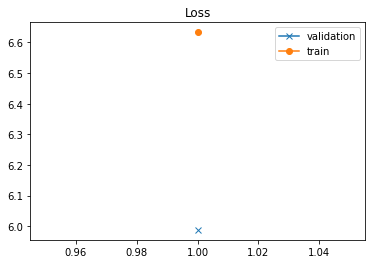

smallest val loss: (1, 5.988104)
Current Lr:  0.0009901111

Time taken for this epoch: 36.92 secs

Epoch 2 Batch 0 Loss 5.8699
Epoch 2 Batch 150 Loss 6.0476
Epoch 2 Batch 300 Loss 5.9998
Epoch 2 Batch 450 Loss 5.9687
Epoch 2 Batch 600 Loss 5.9417
Epoch 2 Batch 750 Loss 5.9147

<UNK> <UNK> <UNK> <UNK> <UNK> <UNK>
bjp <UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK> <UNK>

validation started ...

* Validation loss: 5.634415149688721 

* Train Loss 5.9104

Saving checkpoint for epoch 2 at checkpoints4/ckpt-2


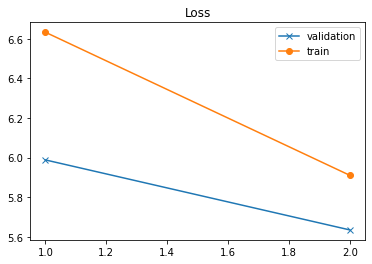

smallest val loss: (2, 5.634415)
Current Lr:  0.00098032

Time taken for this epoch: 25.42 secs

Epoch 3 Batch 0 Loss 5.5284
Epoch 3 Batch 150 Loss 5.6826
Epoch 3 Batch 300 Loss 5.6712
Epoch 3 Batch 450 Loss 5.6523
Epoch 3 Batch 600 Loss 5.6325
Epoch 3 Batch 750 Loss 5.6114

<UNK> <UNK> <UNK> <UNK> <UNK> <UNK>
bjp gandhi gandhi <UNK> <UNK> <UNK> <UNK>
trump asks trump to <UNK> <UNK> <UNK>
pak prez <UNK> <UNK> <UNK> <UNK>

validation started ...

* Validation loss: 5.399899482727051 

* Train Loss 5.6074

Saving checkpoint for epoch 3 at checkpoints4/ckpt-3


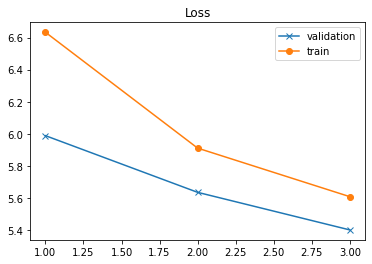

smallest val loss: (3, 5.3998995)
Current Lr:  0.00097062584

Time taken for this epoch: 25.58 secs

Epoch 4 Batch 0 Loss 5.5130
Epoch 4 Batch 150 Loss 5.4101
Epoch 4 Batch 300 Loss 5.4051
Epoch 4 Batch 450 Loss 5.3881
Epoch 4 Batch 600 Loss 5.3749
Epoch 4 Batch 750 Loss 5.3626

<UNK> <UNK> <UNK> <UNK> <UNK> <UNK>
modi <UNK> <UNK> <UNK> <UNK> <UNK> <UNK>
trump <UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK>

validation started ...

* Validation loss: 5.17453670501709 

* Train Loss 5.3590

Saving checkpoint for epoch 4 at checkpoints4/ckpt-4


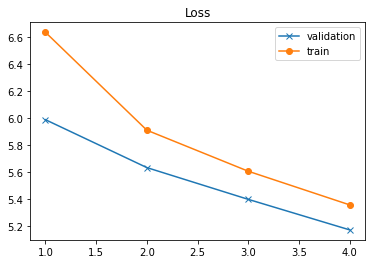

smallest val loss: (4, 5.1745367)
Current Lr:  0.0009610275

Time taken for this epoch: 25.05 secs

Epoch 5 Batch 0 Loss 5.2145
Epoch 5 Batch 150 Loss 5.1785
Epoch 5 Batch 300 Loss 5.1783
Epoch 5 Batch 450 Loss 5.1740
Epoch 5 Batch 600 Loss 5.1669
Epoch 5 Batch 750 Loss 5.1599

<UNK> <UNK> <UNK> <UNK> <UNK> <UNK>
modi <UNK> <UNK> <UNK> <UNK> <UNK>
trump <UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> to win in <UNK>

validation started ...

* Validation loss: 5.008180141448975 

* Train Loss 5.1588

Saving checkpoint for epoch 5 at checkpoints4/ckpt-5


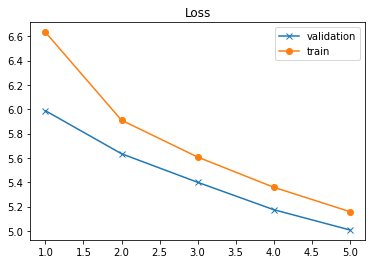

smallest val loss: (5, 5.00818)
Current Lr:  0.00095152395

Time taken for this epoch: 25.08 secs

Epoch 6 Batch 0 Loss 4.9684
Epoch 6 Batch 150 Loss 5.0272
Epoch 6 Batch 300 Loss 5.0091
Epoch 6 Batch 450 Loss 5.0057
Epoch 6 Batch 600 Loss 5.0037
Epoch 6 Batch 750 Loss 5.0004

<UNK> launches <UNK> <UNK> <UNK>
pm modi modi modi modi singh gandhi gandhi gandhi gandhi
trump <UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK> <UNK>

validation started ...

* Validation loss: 4.902615070343018 

* Train Loss 5.0003

Saving checkpoint for epoch 6 at checkpoints4/ckpt-6


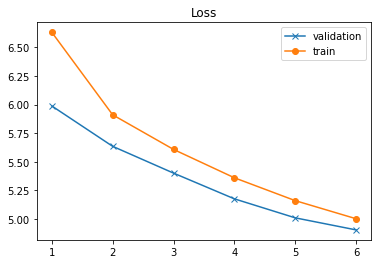

smallest val loss: (6, 4.902615)
Current Lr:  0.00094211457

Time taken for this epoch: 25.68 secs

Epoch 7 Batch 0 Loss 4.9019
Epoch 7 Batch 150 Loss 4.8799
Epoch 7 Batch 300 Loss 4.8784
Epoch 7 Batch 450 Loss 4.8744
Epoch 7 Batch 600 Loss 4.8721
Epoch 7 Batch 750 Loss 4.8668

worlds first hotel opens in us
modi modi slams modi over his <UNK> <UNK>
us prez slams trump over <UNK> <UNK>
<UNK> <UNK> to contest in <UNK>

validation started ...

* Validation loss: 4.768122673034668 

* Train Loss 4.8658

Saving checkpoint for epoch 7 at checkpoints4/ckpt-7


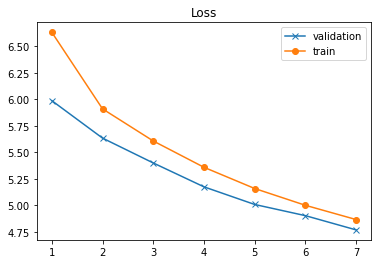

smallest val loss: (7, 4.7681227)
Current Lr:  0.0009327981

Time taken for this epoch: 25.29 secs

Epoch 8 Batch 0 Loss 4.6850
Epoch 8 Batch 150 Loss 4.7549
Epoch 8 Batch 300 Loss 4.7552
Epoch 8 Batch 450 Loss 4.7528
Epoch 8 Batch 600 Loss 4.7528
Epoch 8 Batch 750 Loss 4.7574

<UNK> <UNK> opens in us airport
modi modi <UNK> <UNK> <UNK> <UNK>
trump slams trump over <UNK> <UNK> <UNK>
<UNK> <UNK> elected as <UNK> <UNK>

validation started ...

* Validation loss: 4.706161975860596 

* Train Loss 4.7568


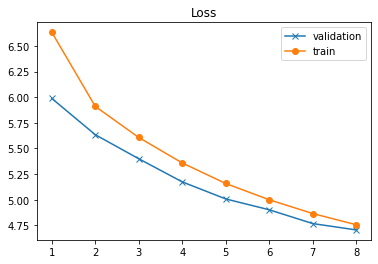

smallest val loss: (8, 4.706162)
Current Lr:  0.00092357374

Time taken for this epoch: 24.97 secs

Epoch 9 Batch 0 Loss 4.7418
Epoch 9 Batch 150 Loss 4.6454
Epoch 9 Batch 300 Loss 4.6564
Epoch 9 Batch 450 Loss 4.6519
Epoch 9 Batch 600 Loss 4.6541
Epoch 9 Batch 750 Loss 4.6615

<UNK> <UNK> <UNK> <UNK> <UNK>
modi modi modi <UNK> modi modi modi
us prez slams trump over <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK>

validation started ...

* Validation loss: 4.623180389404297 

* Train Loss 4.6612

Saving checkpoint for epoch 9 at checkpoints4/ckpt-8


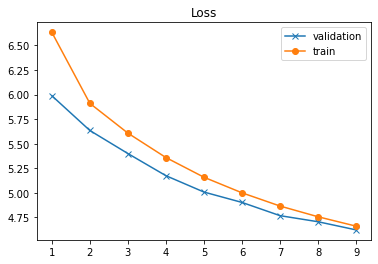

smallest val loss: (9, 4.6231804)
Current Lr:  0.0009144407

Time taken for this epoch: 24.90 secs

Epoch 10 Batch 0 Loss 4.4412
Epoch 10 Batch 150 Loss 4.5578
Epoch 10 Batch 300 Loss 4.5643
Epoch 10 Batch 450 Loss 4.5693
Epoch 10 Batch 600 Loss 4.5723
Epoch 10 Batch 750 Loss 4.5788

dubai to host <UNK> <UNK> hotel
modi modi modi modi modi modi modi modi on his birthday
<UNK> is <UNK> <UNK> <UNK> <UNK>
<UNK> prez to be <UNK> in <UNK>

validation started ...

* Validation loss: 4.569821357727051 

* Train Loss 4.5795


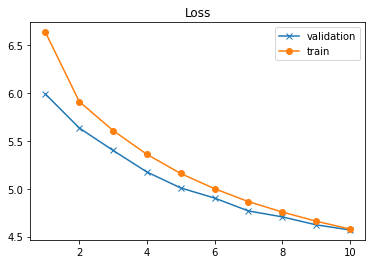

smallest val loss: (10, 4.5698214)
Current Lr:  0.00090539793

Time taken for this epoch: 25.41 secs

Epoch 11 Batch 0 Loss 4.3901
Epoch 11 Batch 150 Loss 4.4726
Epoch 11 Batch 300 Loss 4.4923
Epoch 11 Batch 450 Loss 4.5015
Epoch 11 Batch 600 Loss 4.5059
Epoch 11 Batch 750 Loss 4.5118

<UNK> opens in <UNK> hotel
modi modi modi modi <UNK> modi on his birthday
trump slams trump for <UNK> <UNK>
<UNK> <UNK> <UNK> elected in <UNK>

validation started ...

* Validation loss: 4.507587432861328 

* Train Loss 4.5141

Saving checkpoint for epoch 11 at checkpoints4/ckpt-9


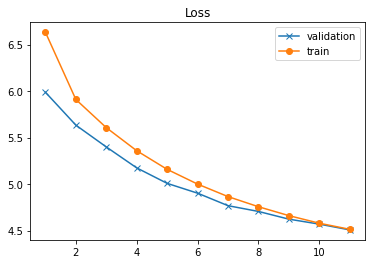

smallest val loss: (11, 4.5075874)
Current Lr:  0.00089644454

Time taken for this epoch: 25.03 secs

Epoch 12 Batch 0 Loss 4.3944
Epoch 12 Batch 150 Loss 4.4179
Epoch 12 Batch 300 Loss 4.4253
Epoch 12 Batch 450 Loss 4.4374
Epoch 12 Batch 600 Loss 4.4458
Epoch 12 Batch 750 Loss 4.4534

<UNK> hotel opens in london
modi modi wishes modi to modi modi
<UNK> is <UNK> <UNK> us prez
<UNK> prez to be <UNK> in <UNK>

validation started ...

* Validation loss: 4.45620584487915 

* Train Loss 4.4547


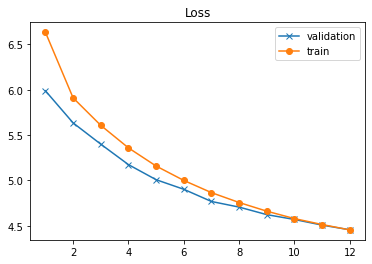

smallest val loss: (12, 4.456206)
Current Lr:  0.00088757975

Time taken for this epoch: 25.04 secs

Epoch 13 Batch 0 Loss 4.3503
Epoch 13 Batch 150 Loss 4.3506
Epoch 13 Batch 300 Loss 4.3721
Epoch 13 Batch 450 Loss 4.3831
Epoch 13 Batch 600 Loss 4.3919
Epoch 13 Batch 750 Loss 4.3981

<UNK> hotel opens in paris
modi modi wishes pm modi modi to modi modi
us prez calls for <UNK> <UNK> <UNK>
<UNK> <UNK> wins <UNK> <UNK>

validation started ...

* Validation loss: 4.430201530456543 

* Train Loss 4.4006


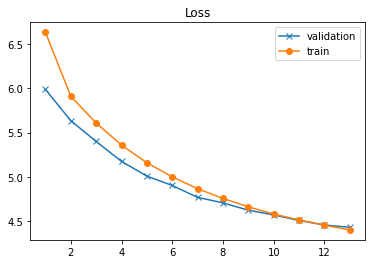

smallest val loss: (13, 4.4302015)
Current Lr:  0.00087880256

Time taken for this epoch: 24.85 secs

Epoch 14 Batch 0 Loss 4.3230
Epoch 14 Batch 150 Loss 4.3248
Epoch 14 Batch 300 Loss 4.3287
Epoch 14 Batch 450 Loss 4.3383
Epoch 14 Batch 600 Loss 4.3443
Epoch 14 Batch 750 Loss 4.3549

dubai opens for <UNK> <UNK>
modi wishes pm modi modi on his birthday
us prez calls for <UNK> <UNK> <UNK>
<UNK> <UNK> to be held in <UNK>

validation started ...

* Validation loss: 4.38753604888916 

* Train Loss 4.3554

Saving checkpoint for epoch 14 at checkpoints4/ckpt-10


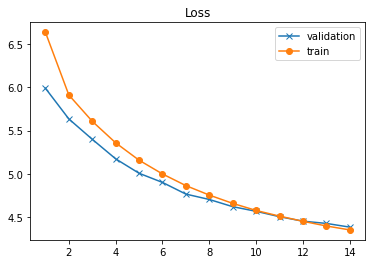

smallest val loss: (14, 4.387536)
Current Lr:  0.0008701122

Time taken for this epoch: 25.36 secs

Epoch 15 Batch 0 Loss 4.3195
Epoch 15 Batch 150 Loss 4.2620
Epoch 15 Batch 300 Loss 4.2814
Epoch 15 Batch 450 Loss 4.2987
Epoch 15 Batch 600 Loss 4.3071
Epoch 15 Batch 750 Loss 4.3160

paris museum opens in paris
modi modi wishes modi modi modi to modi modi
us <UNK> <UNK> <UNK> <UNK> trump
<UNK> prez to be first <UNK> in <UNK>

validation started ...

* Validation loss: 4.382476329803467 

* Train Loss 4.3178


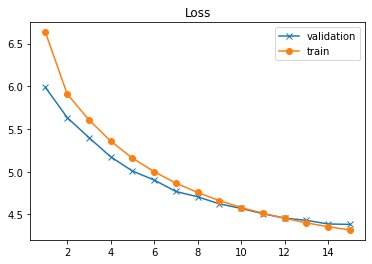

smallest val loss: (15, 4.3824763)
Current Lr:  0.00086150784

Time taken for this epoch: 25.43 secs

Epoch 16 Batch 0 Loss 4.1020
Epoch 16 Batch 150 Loss 4.2367
Epoch 16 Batch 300 Loss 4.2478
Epoch 16 Batch 450 Loss 4.2633
Epoch 16 Batch 600 Loss 4.2709
Epoch 16 Batch 750 Loss 4.2810

volkswagen opens <UNK> hotel for a hotel
modi wishes modi modi modi on his birthday
<UNK> <UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> st phase of <UNK>

validation started ...

* Validation loss: 4.3170647621154785 

* Train Loss 4.2823


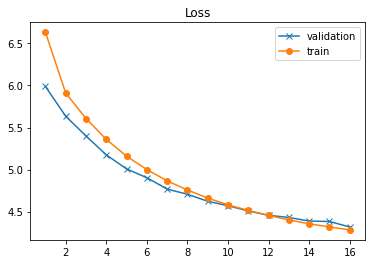

smallest val loss: (16, 4.317065)
Current Lr:  0.00085298845

Time taken for this epoch: 25.19 secs

Epoch 17 Batch 0 Loss 4.0658
Epoch 17 Batch 150 Loss 4.2142
Epoch 17 Batch 300 Loss 4.2227
Epoch 17 Batch 450 Loss 4.2310
Epoch 17 Batch 600 Loss 4.2401
Epoch 17 Batch 750 Loss 4.2481

paris opens new york airport
modi asks pm modi to modi for his th birthday
us <UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> to be st prez to be elected

validation started ...

* Validation loss: 4.300389289855957 

* Train Loss 4.2507


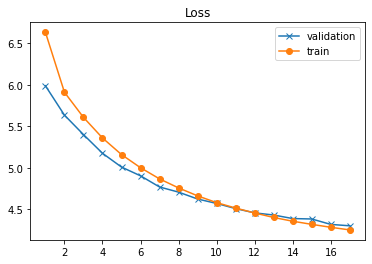

smallest val loss: (17, 4.3003893)
Current Lr:  0.0008445534

Time taken for this epoch: 29.27 secs

Epoch 18 Batch 0 Loss 4.2447
Epoch 18 Batch 150 Loss 4.1870
Epoch 18 Batch 300 Loss 4.1977
Epoch 18 Batch 450 Loss 4.2041
Epoch 18 Batch 600 Loss 4.2119
Epoch 18 Batch 750 Loss 4.2209

<UNK> hotel opens in germany
modi wishes pm modi modi on his birthday
<UNK> is <UNK> of <UNK> <UNK> <UNK>
<UNK> <UNK> to be st prez in yrs

validation started ...

* Validation loss: 4.27674674987793 

* Train Loss 4.2215

Saving checkpoint for epoch 18 at checkpoints4/ckpt-11


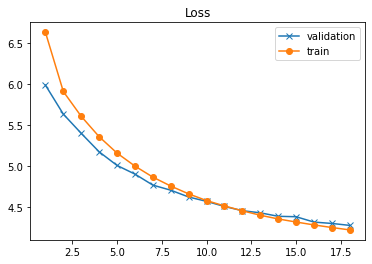

smallest val loss: (18, 4.2767467)
Current Lr:  0.00083620177

Time taken for this epoch: 25.47 secs

Epoch 19 Batch 0 Loss 4.2059
Epoch 19 Batch 150 Loss 4.1355
Epoch 19 Batch 300 Loss 4.1489
Epoch 19 Batch 450 Loss 4.1692
Epoch 19 Batch 600 Loss 4.1809
Epoch 19 Batch 750 Loss 4.1928

bmw opens <UNK> hotel in germany
modi kejriwal wishes pm modi modi modi on his birthday
us <UNK> <UNK> <UNK> <UNK> <UNK>
myanmar to be st <UNK> in years

validation started ...

* Validation loss: 4.283491611480713 

* Train Loss 4.1939


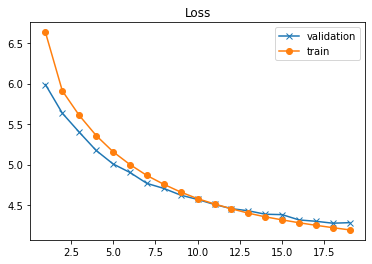

smallest val loss: (18, 4.2767467)
Current Lr:  0.0008279326

Time taken for this epoch: 25.43 secs

Epoch 20 Batch 0 Loss 4.0041
Epoch 20 Batch 150 Loss 4.1210
Epoch 20 Batch 300 Loss 4.1450
Epoch 20 Batch 450 Loss 4.1521
Epoch 20 Batch 600 Loss 4.1599
Epoch 20 Batch 750 Loss 4.1693

<UNK> museum opens in germany
modi wishes modi on his birthday
<UNK> <UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> to be st <UNK> in <UNK>

validation started ...

* Validation loss: 4.235642433166504 

* Train Loss 4.1711


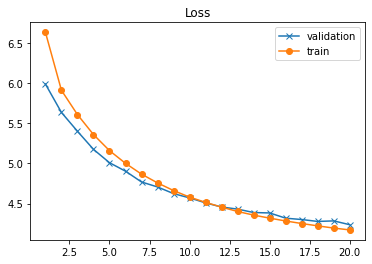

smallest val loss: (20, 4.2356424)
Current Lr:  0.0008197454

Time taken for this epoch: 24.62 secs

Epoch 21 Batch 0 Loss 3.9203
Epoch 21 Batch 150 Loss 4.0769
Epoch 21 Batch 300 Loss 4.1115
Epoch 21 Batch 450 Loss 4.1229
Epoch 21 Batch 600 Loss 4.1322
Epoch 21 Batch 750 Loss 4.1467

bmw opens in germany for <UNK> <UNK>
modi wishes pm modi to pm modi on his birthday
donald trump is <UNK> <UNK> <UNK>
<UNK> <UNK> st <UNK> to be st prez

validation started ...

* Validation loss: 4.218847274780273 

* Train Loss 4.1489


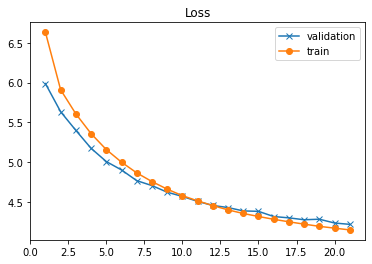

smallest val loss: (21, 4.2188473)
Current Lr:  0.00081163907

Time taken for this epoch: 25.62 secs

Epoch 22 Batch 0 Loss 3.7467
Epoch 22 Batch 150 Loss 4.0708
Epoch 22 Batch 300 Loss 4.0991
Epoch 22 Batch 450 Loss 4.1096
Epoch 22 Batch 600 Loss 4.1175
Epoch 22 Batch 750 Loss 4.1294

volkswagen opens <UNK> hotel in germany
kejriwal wishes pm modi to modi on his birthday
is <UNK> is a <UNK> is <UNK> is <UNK> <UNK>
<UNK> <UNK> to be <UNK> in <UNK>

validation started ...

* Validation loss: 4.204248428344727 

* Train Loss 4.1299


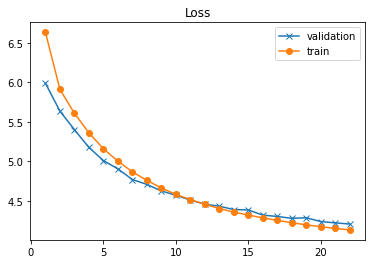

smallest val loss: (22, 4.2042484)
Current Lr:  0.0008036128

Time taken for this epoch: 25.85 secs

Epoch 23 Batch 0 Loss 3.8285
Epoch 23 Batch 150 Loss 4.0436
Epoch 23 Batch 300 Loss 4.0684
Epoch 23 Batch 450 Loss 4.0839
Epoch 23 Batch 600 Loss 4.0983
Epoch 23 Batch 750 Loss 4.1101

luxury hotel opens in germany
modi modi wishes modi on his birthday
us <UNK> <UNK> <UNK> <UNK> <UNK>
myanmar to conduct <UNK> <UNK> in yrs

validation started ...

* Validation loss: 4.1688079833984375 

* Train Loss 4.1124

Saving checkpoint for epoch 23 at checkpoints4/ckpt-12


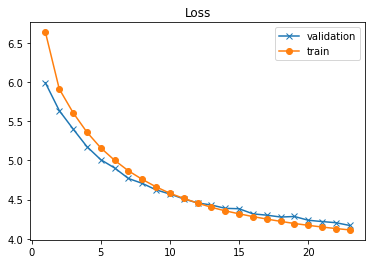

smallest val loss: (23, 4.168808)
Current Lr:  0.000795666

Time taken for this epoch: 25.37 secs

Epoch 24 Batch 0 Loss 4.0639
Epoch 24 Batch 150 Loss 4.0318
Epoch 24 Batch 300 Loss 4.0544
Epoch 24 Batch 450 Loss 4.0696
Epoch 24 Batch 600 Loss 4.0800
Epoch 24 Batch 750 Loss 4.0929

luxury hotel opens in germany
modi modi wishes modi on pm modi on pm modi
us <UNK> <UNK> <UNK> <UNK> <UNK> trump
myanmar to <UNK> <UNK> <UNK> in st time

validation started ...

* Validation loss: 4.1824259757995605 

* Train Loss 4.0932


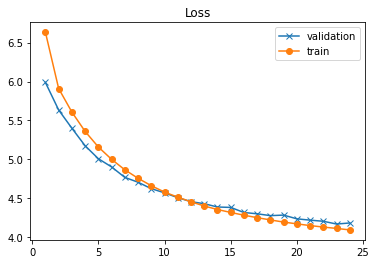

smallest val loss: (23, 4.168808)
Current Lr:  0.0007877978

Time taken for this epoch: 25.59 secs

Epoch 25 Batch 0 Loss 4.0269
Epoch 25 Batch 150 Loss 4.0225
Epoch 25 Batch 300 Loss 4.0436
Epoch 25 Batch 450 Loss 4.0562
Epoch 25 Batch 600 Loss 4.0652
Epoch 25 Batch 750 Loss 4.0783

bmw opens for <UNK> <UNK> <UNK>
modi modi wishes pm modi on his birthday
us prez <UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> to be <UNK> <UNK>

validation started ...

* Validation loss: 4.161865711212158 

* Train Loss 4.0802


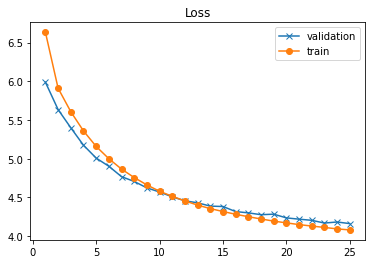

smallest val loss: (25, 4.1618657)
Current Lr:  0.00078000734

Time taken for this epoch: 25.46 secs

Epoch 26 Batch 0 Loss 3.9140
Epoch 26 Batch 150 Loss 3.9965
Epoch 26 Batch 300 Loss 4.0171
Epoch 26 Batch 450 Loss 4.0354
Epoch 26 Batch 600 Loss 4.0497
Epoch 26 Batch 750 Loss 4.0595

bmw hosts <UNK> hotel in germany
pm modi wishes pm modi on his birthday
un chief <UNK> <UNK> <UNK> <UNK> <UNK>
suu kyi kyi kyi kyi kyi kyi kyi

validation started ...

* Validation loss: 4.149799823760986 

* Train Loss 4.0614


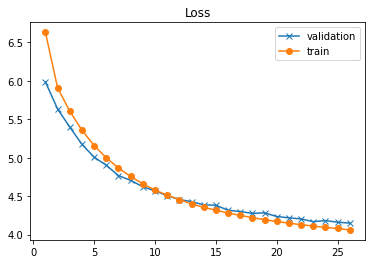

smallest val loss: (26, 4.1498)
Current Lr:  0.00077229395

Time taken for this epoch: 25.41 secs

Epoch 27 Batch 0 Loss 4.1407
Epoch 27 Batch 150 Loss 3.9846
Epoch 27 Batch 300 Loss 4.0009
Epoch 27 Batch 450 Loss 4.0153
Epoch 27 Batch 600 Loss 4.0263
Epoch 27 Batch 750 Loss 4.0432

<UNK> hotel is a hotel in germany
modi asks pm modi to modi for his birthday
us <UNK> <UNK> <UNK> <UNK> <UNK> trump
<UNK> <UNK> to be <UNK> in <UNK>

validation started ...

* Validation loss: 4.148421764373779 

* Train Loss 4.0454


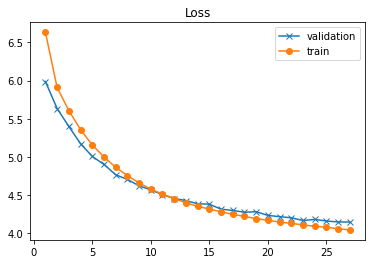

smallest val loss: (27, 4.148422)
Current Lr:  0.00076465687

Time taken for this epoch: 25.79 secs

Epoch 28 Batch 0 Loss 4.1315
Epoch 28 Batch 150 Loss 3.9797
Epoch 28 Batch 300 Loss 3.9906
Epoch 28 Batch 450 Loss 4.0044
Epoch 28 Batch 600 Loss 4.0169
Epoch 28 Batch 750 Loss 4.0312

porsche opens worlds first <UNK> hotel
modi wishes modi on pm modi on his birthday
us <UNK> <UNK> <UNK> <UNK> <UNK> <UNK>
myanmar to get first <UNK> <UNK>

validation started ...

* Validation loss: 4.135100841522217 

* Train Loss 4.0335


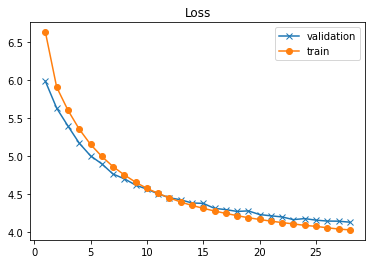

smallest val loss: (28, 4.135101)
Current Lr:  0.00075709523

Time taken for this epoch: 25.27 secs

Epoch 29 Batch 0 Loss 3.9026
Epoch 29 Batch 150 Loss 3.9557
Epoch 29 Batch 300 Loss 3.9742
Epoch 29 Batch 450 Loss 3.9921
Epoch 29 Batch 600 Loss 4.0071
Epoch 29 Batch 750 Loss 4.0177

<UNK> hotel opens in germany
mamata asks pm modi to receive pm modi on his birthday
<UNK> is a <UNK> of <UNK> is <UNK>
<UNK> <UNK> to be elected in <UNK>

validation started ...

* Validation loss: 4.095970630645752 

* Train Loss 4.0204


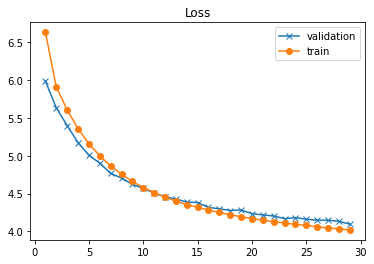

smallest val loss: (29, 4.0959706)
Current Lr:  0.0007496085

Time taken for this epoch: 25.50 secs

Epoch 30 Batch 0 Loss 3.8117
Epoch 30 Batch 150 Loss 3.9615
Epoch 30 Batch 300 Loss 3.9727
Epoch 30 Batch 450 Loss 3.9851
Epoch 30 Batch 600 Loss 4.0007
Epoch 30 Batch 750 Loss 4.0099

bmw opens museum for <UNK> museum
modi modi wishes modi on his birthday
us <UNK> <UNK> <UNK> <UNK> <UNK> <UNK>
myanmar to get first <UNK> <UNK>

validation started ...

* Validation loss: 4.1225056648254395 

* Train Loss 4.0106


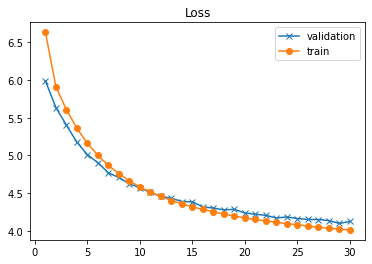

smallest val loss: (29, 4.0959706)
Current Lr:  0.0007421957

Time taken for this epoch: 24.97 secs

Epoch 31 Batch 0 Loss 3.9745
Epoch 31 Batch 150 Loss 3.9393
Epoch 31 Batch 300 Loss 3.9694
Epoch 31 Batch 450 Loss 3.9730
Epoch 31 Batch 600 Loss 3.9864
Epoch 31 Batch 750 Loss 3.9980

germany opens its first hotel in germany
pm modi asks pm modi to <UNK> pm modi on his th
un <UNK> <UNK> <UNK> <UNK> <UNK>
myanmar to be first to win first prez of first time

validation started ...

* Validation loss: 4.1335673332214355 

* Train Loss 3.9984


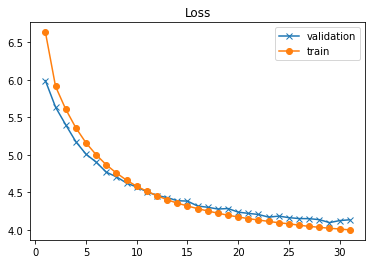

smallest val loss: (29, 4.0959706)
Current Lr:  0.00073485624

Time taken for this epoch: 26.40 secs

Epoch 32 Batch 0 Loss 3.9953
Epoch 32 Batch 150 Loss 3.9250
Epoch 32 Batch 300 Loss 3.9470
Epoch 32 Batch 450 Loss 3.9609
Epoch 32 Batch 600 Loss 3.9705
Epoch 32 Batch 750 Loss 3.9859

bmw hosts <UNK> hotel in germany
modi wishes modi on his birthday
us prez calls for <UNK> <UNK> <UNK>
myanmar to be st <UNK> to join prez

validation started ...

* Validation loss: 4.099227428436279 

* Train Loss 3.9869


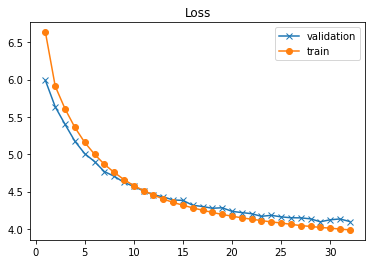

smallest val loss: (29, 4.0959706)
Current Lr:  0.00072758936

Time taken for this epoch: 24.93 secs

Epoch 33 Batch 0 Loss 3.8797
Epoch 33 Batch 150 Loss 3.9255
Epoch 33 Batch 300 Loss 3.9260
Epoch 33 Batch 450 Loss 3.9470
Epoch 33 Batch 600 Loss 3.9604
Epoch 33 Batch 750 Loss 3.9720

<UNK> hotel in germany opens in germany
modi wishes modi on his birthday
us <UNK> <UNK> <UNK> <UNK> <UNK>
myanmar to get first <UNK> <UNK> in years

validation started ...

* Validation loss: 4.089034557342529 

* Train Loss 3.9757


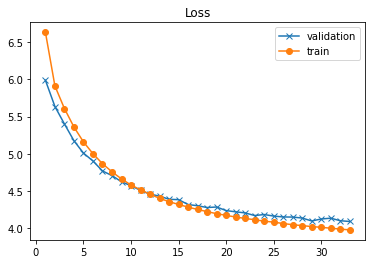

smallest val loss: (33, 4.0890346)
Current Lr:  0.00072039437

Time taken for this epoch: 25.23 secs

Epoch 34 Batch 0 Loss 4.0045
Epoch 34 Batch 150 Loss 3.8834
Epoch 34 Batch 300 Loss 3.9159
Epoch 34 Batch 450 Loss 3.9351
Epoch 34 Batch 600 Loss 3.9485
Epoch 34 Batch 750 Loss 3.9625

porsche opens <UNK> hotel in germany
modi wishes modi on his birthday modi on modi
us <UNK> <UNK> <UNK> <UNK> <UNK> <UNK>
myanmar to get first <UNK> <UNK>

validation started ...

* Validation loss: 4.071621417999268 

* Train Loss 3.9651


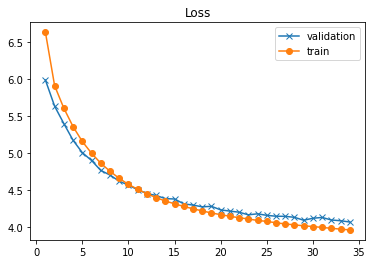

smallest val loss: (34, 4.0716214)
Current Lr:  0.0007132704

Time taken for this epoch: 25.16 secs

Epoch 35 Batch 0 Loss 3.9596
Epoch 35 Batch 150 Loss 3.8975
Epoch 35 Batch 300 Loss 3.9162
Epoch 35 Batch 450 Loss 3.9212
Epoch 35 Batch 600 Loss 3.9357
Epoch 35 Batch 750 Loss 3.9514

<UNK> hotel opens in germany
kejriwal wishes modi on his birthday
us <UNK> <UNK> <UNK> <UNK> <UNK>
myanmar to get st <UNK> <UNK> in yrs

validation started ...

* Validation loss: 4.056621074676514 

* Train Loss 3.9529

Saving checkpoint for epoch 35 at checkpoints4/ckpt-13


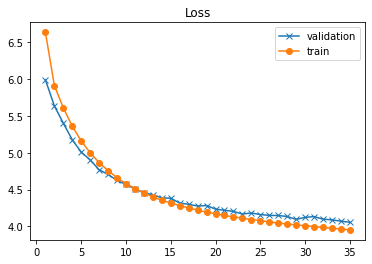

smallest val loss: (35, 4.056621)
Current Lr:  0.000706217

Time taken for this epoch: 25.36 secs

Epoch 36 Batch 0 Loss 3.7396
Epoch 36 Batch 150 Loss 3.8755
Epoch 36 Batch 300 Loss 3.9053
Epoch 36 Batch 450 Loss 3.9149
Epoch 36 Batch 600 Loss 3.9284
Epoch 36 Batch 750 Loss 3.9427

porsche opens <UNK> hotel in germany
modi wishes modi on his th birthday
us <UNK> <UNK> <UNK> <UNK> <UNK>
myanmar to get first state party party

validation started ...

* Validation loss: 4.074530124664307 

* Train Loss 3.9438


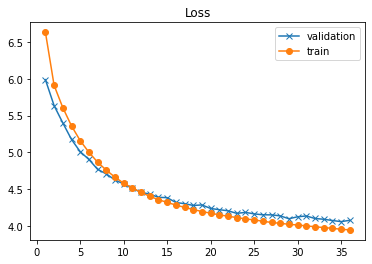

smallest val loss: (35, 4.056621)
Current Lr:  0.00069923326

Time taken for this epoch: 24.68 secs

Epoch 37 Batch 0 Loss 3.8177
Epoch 37 Batch 150 Loss 3.8790
Epoch 37 Batch 300 Loss 3.8987
Epoch 37 Batch 450 Loss 3.9104
Epoch 37 Batch 600 Loss 3.9246
Epoch 37 Batch 750 Loss 3.9322

<UNK> hotel opens for <UNK> hotel
modi wishes modi on his birthday
<UNK> <UNK> <UNK> <UNK> <UNK> <UNK>
myanmar to get first presidents rule

validation started ...

* Validation loss: 4.047374248504639 

* Train Loss 3.9346


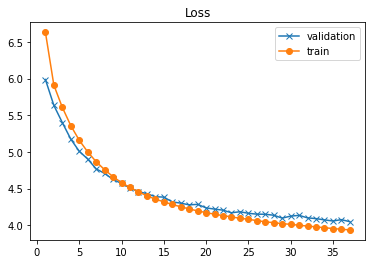

smallest val loss: (37, 4.0473742)
Current Lr:  0.0006923187

Time taken for this epoch: 25.07 secs

Epoch 38 Batch 0 Loss 3.9244
Epoch 38 Batch 150 Loss 3.8543
Epoch 38 Batch 300 Loss 3.8845
Epoch 38 Batch 450 Loss 3.8968
Epoch 38 Batch 600 Loss 3.9108
Epoch 38 Batch 750 Loss 3.9228

porsche opens its <UNK> hotel in germany
modi thanks mamata on his birthday
un <UNK> <UNK> <UNK> <UNK> <UNK>
myanmar to get first <UNK> <UNK>

validation started ...

* Validation loss: 4.0431365966796875 

* Train Loss 3.9254


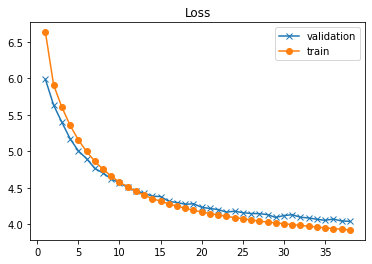

smallest val loss: (38, 4.0431366)
Current Lr:  0.00068547245

Time taken for this epoch: 24.88 secs

Epoch 39 Batch 0 Loss 3.7972
Epoch 39 Batch 150 Loss 3.8473
Epoch 39 Batch 300 Loss 3.8729
Epoch 39 Batch 450 Loss 3.8868
Epoch 39 Batch 600 Loss 3.8984
Epoch 39 Batch 750 Loss 3.9122

bmw hotel has a hotel in germany
kejriwal wishes modi on his birthday
us prez calls for <UNK> <UNK> <UNK>
myanmar to be st <UNK> to be <UNK>

validation started ...

* Validation loss: 4.043823719024658 

* Train Loss 3.9148


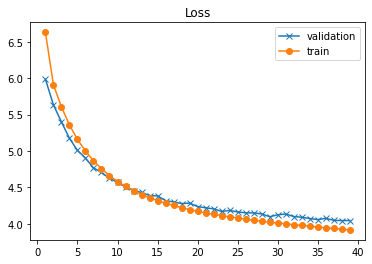

smallest val loss: (38, 4.0431366)
Current Lr:  0.00067869393

Time taken for this epoch: 25.27 secs

Epoch 40 Batch 0 Loss 3.7374
Epoch 40 Batch 150 Loss 3.8454
Epoch 40 Batch 300 Loss 3.8655
Epoch 40 Batch 450 Loss 3.8795
Epoch 40 Batch 600 Loss 3.8902
Epoch 40 Batch 750 Loss 3.9052

bmw has a hotel in germany
modi thanks mamata on his birthday
us <UNK> <UNK> <UNK> <UNK> <UNK> <UNK>
myanmar to get first <UNK> party

validation started ...

* Validation loss: 4.050943374633789 

* Train Loss 3.9082


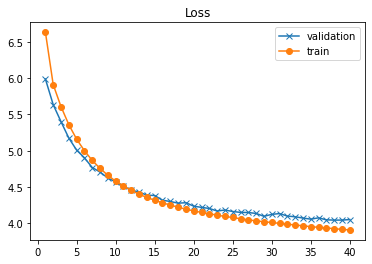

smallest val loss: (38, 4.0431366)
Current Lr:  0.0006719824

Time taken for this epoch: 25.02 secs

Epoch 41 Batch 0 Loss 3.6447
Epoch 41 Batch 150 Loss 3.8435
Epoch 41 Batch 300 Loss 3.8442
Epoch 41 Batch 450 Loss 3.8674
Epoch 41 Batch 600 Loss 3.8835
Epoch 41 Batch 750 Loss 3.8982

audi hotel to get <UNK> hotel in germany
modi congratulates modi on his th birthday
trump <UNK> <UNK> <UNK> <UNK> <UNK>
myanmar to get first <UNK> <UNK>

validation started ...

* Validation loss: 4.047786712646484 

* Train Loss 3.8996


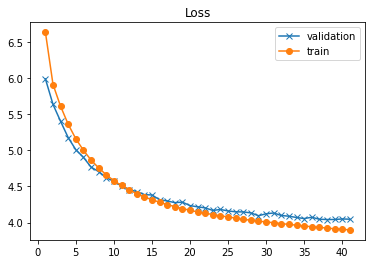

smallest val loss: (38, 4.0431366)
Current Lr:  0.0006653373

Time taken for this epoch: 25.17 secs

Epoch 42 Batch 0 Loss 3.7786
Epoch 42 Batch 150 Loss 3.8257
Epoch 42 Batch 300 Loss 3.8410
Epoch 42 Batch 450 Loss 3.8554
Epoch 42 Batch 600 Loss 3.8706
Epoch 42 Batch 750 Loss 3.8879

bmw <UNK> hotel to be <UNK> in germany
modi thanks modi for modi on his birthday
us prez calls for human rights <UNK>
myanmar to be st state to be elected

validation started ...

* Validation loss: 4.010894298553467 

* Train Loss 3.8913


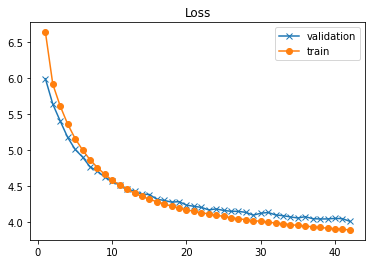

smallest val loss: (42, 4.0108943)
Current Lr:  0.0006587578

Time taken for this epoch: 25.64 secs

Epoch 43 Batch 0 Loss 3.7890
Epoch 43 Batch 150 Loss 3.8182
Epoch 43 Batch 300 Loss 3.8395
Epoch 43 Batch 450 Loss 3.8563
Epoch 43 Batch 600 Loss 3.8697
Epoch 43 Batch 750 Loss 3.8834

bmw builds <UNK> hotel in germany
modi wishes modi on his birthday
trump has <UNK> <UNK> <UNK> <UNK> un chief
myanmar to be first state to be <UNK>

validation started ...

* Validation loss: 3.9962944984436035 

* Train Loss 3.8853


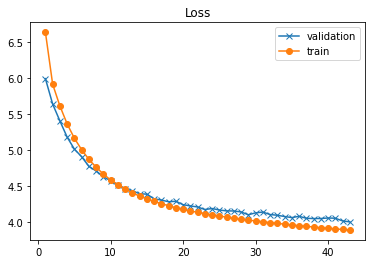

smallest val loss: (43, 3.9962945)
Current Lr:  0.0006522435

Time taken for this epoch: 28.98 secs

Epoch 44 Batch 0 Loss 4.0286
Epoch 44 Batch 150 Loss 3.8097
Epoch 44 Batch 300 Loss 3.8357
Epoch 44 Batch 450 Loss 3.8467
Epoch 44 Batch 600 Loss 3.8602
Epoch 44 Batch 750 Loss 3.8727

bmw museum to build <UNK> hotel
modi thanks pm modi for his birthday
trump <UNK> <UNK> <UNK> <UNK> <UNK>
myanmar to get first <UNK> <UNK>

validation started ...

* Validation loss: 4.023771286010742 

* Train Loss 3.8761


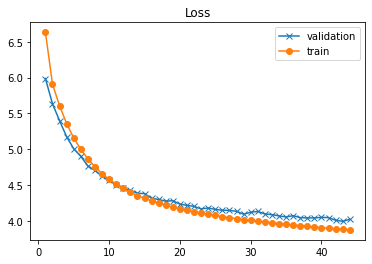

smallest val loss: (43, 3.9962945)
Current Lr:  0.00064579357

Time taken for this epoch: 25.16 secs

Epoch 45 Batch 0 Loss 3.8281
Epoch 45 Batch 150 Loss 3.8083
Epoch 45 Batch 300 Loss 3.8274
Epoch 45 Batch 450 Loss 3.8314
Epoch 45 Batch 600 Loss 3.8458
Epoch 45 Batch 750 Loss 3.8615

germany has a hotel to be a hotel
modi wishes modi on his th bday
us <UNK> <UNK> <UNK> <UNK> <UNK>
myanmar to get first <UNK> first <UNK>

validation started ...

* Validation loss: 4.008768081665039 

* Train Loss 3.8639


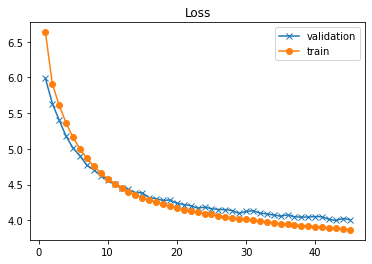

smallest val loss: (43, 3.9962945)
Current Lr:  0.0006394074

Time taken for this epoch: 25.31 secs

Epoch 46 Batch 0 Loss 3.7919
Epoch 46 Batch 150 Loss 3.7946
Epoch 46 Batch 300 Loss 3.8078
Epoch 46 Batch 450 Loss 3.8323
Epoch 46 Batch 600 Loss 3.8442
Epoch 46 Batch 750 Loss 3.8561

bmw is a hotel in germany
modi praises modi for th bday on his th bday
trump <UNK> <UNK> <UNK> <UNK> <UNK>
myanmar to be st <UNK> to be <UNK>

validation started ...

* Validation loss: 3.994037389755249 

* Train Loss 3.8584


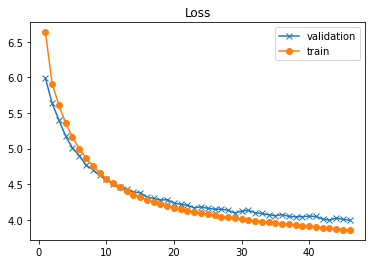

smallest val loss: (46, 3.9940374)
Current Lr:  0.0006330844

Time taken for this epoch: 25.83 secs

Epoch 47 Batch 0 Loss 3.7175
Epoch 47 Batch 150 Loss 3.7900
Epoch 47 Batch 300 Loss 3.7977
Epoch 47 Batch 450 Loss 3.8136
Epoch 47 Batch 600 Loss 3.8291
Epoch 47 Batch 750 Loss 3.8458

porsche <UNK> hotel in germany
pm modi wishes pm modi on his birthday
us <UNK> <UNK> <UNK> of human rights <UNK>
myanmar to be st state to be st state to be <UNK>

validation started ...

* Validation loss: 4.00550651550293 

* Train Loss 3.8480


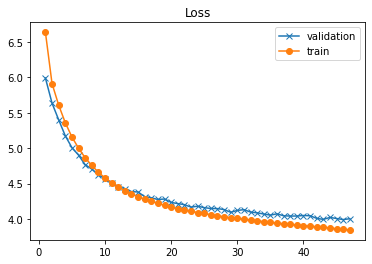

smallest val loss: (46, 3.9940374)
Current Lr:  0.00062682386

Time taken for this epoch: 26.04 secs

Epoch 48 Batch 0 Loss 3.8057
Epoch 48 Batch 150 Loss 3.7663
Epoch 48 Batch 300 Loss 3.7933
Epoch 48 Batch 450 Loss 3.8104
Epoch 48 Batch 600 Loss 3.8266
Epoch 48 Batch 750 Loss 3.8426

bmw is a hotel in germany
modi wishes modi on his th birthday
us <UNK> <UNK> <UNK> <UNK> <UNK>
myanmar to be st <UNK> as prez rule

validation started ...

* Validation loss: 3.9693543910980225 

* Train Loss 3.8447


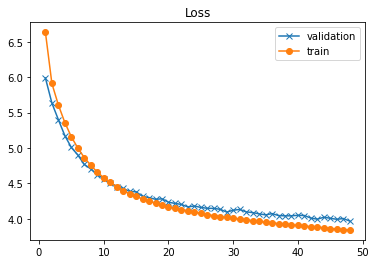

smallest val loss: (48, 3.9693544)
Current Lr:  0.00062062533

Time taken for this epoch: 25.05 secs

Epoch 49 Batch 0 Loss 3.8988
Epoch 49 Batch 150 Loss 3.7686
Epoch 49 Batch 300 Loss 3.7913
Epoch 49 Batch 450 Loss 3.8087
Epoch 49 Batch 600 Loss 3.8212
Epoch 49 Batch 750 Loss 3.8373

bmw <UNK> hotel to be <UNK> in germany
modi wishes pm modi on his th birthday
trump calls for <UNK> <UNK> <UNK> <UNK>
myanmar to be st prez to be <UNK> prez

validation started ...

* Validation loss: 3.9785995483398438 

* Train Loss 3.8391


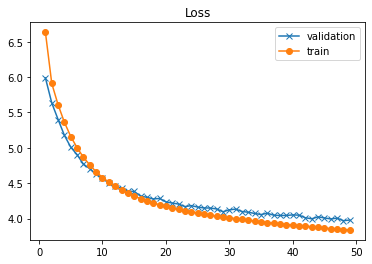

smallest val loss: (48, 3.9693544)
Current Lr:  0.00061448803

Time taken for this epoch: 25.86 secs

Epoch 50 Batch 0 Loss 3.6351
Epoch 50 Batch 150 Loss 3.7613
Epoch 50 Batch 300 Loss 3.7786
Epoch 50 Batch 450 Loss 3.7960
Epoch 50 Batch 600 Loss 3.8116
Epoch 50 Batch 750 Loss 3.8267

bmw is a hotel in germany
modi wishes modi on his birthday
us prez calls for <UNK> <UNK> <UNK>
myanmar to be st <UNK> <UNK> prez

validation started ...

* Validation loss: 4.001643657684326 

* Train Loss 3.8301


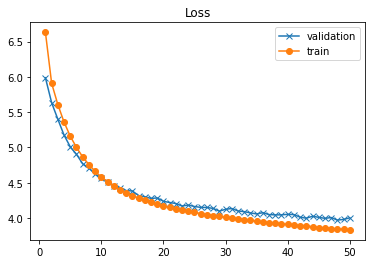

smallest val loss: (48, 3.9693544)
Current Lr:  0.00060841144

Time taken for this epoch: 25.23 secs

Epoch 51 Batch 0 Loss 3.8362
Epoch 51 Batch 150 Loss 3.7766
Epoch 51 Batch 300 Loss 3.7861
Epoch 51 Batch 450 Loss 3.8049
Epoch 51 Batch 600 Loss 3.8150
Epoch 51 Batch 750 Loss 3.8222

porsche offers <UNK> hotel in germany
modi wishes mamata on his birthday
trump is <UNK> <UNK> of <UNK> <UNK>
myanmar to be st prez to be <UNK> prez

validation started ...

* Validation loss: 3.9787397384643555 

* Train Loss 3.8256


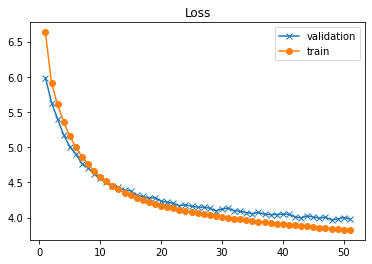

smallest val loss: (48, 3.9693544)
Current Lr:  0.0006023949

Time taken for this epoch: 25.08 secs

Epoch 52 Batch 0 Loss 3.6456
Epoch 52 Batch 150 Loss 3.7626
Epoch 52 Batch 300 Loss 3.7826
Epoch 52 Batch 450 Loss 3.7877
Epoch 52 Batch 600 Loss 3.8042
Epoch 52 Batch 750 Loss 3.8145

porsche opens <UNK> hotel in germany
modi thanks modi on his th birthday
trump <UNK> <UNK> <UNK> <UNK> <UNK>
myanmar to be first to be <UNK> in yrs

validation started ...

* Validation loss: 3.9720990657806396 

* Train Loss 3.8169


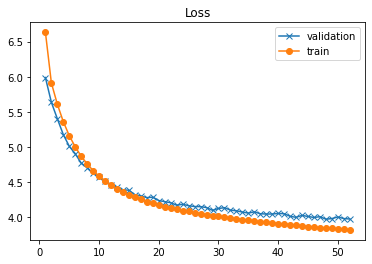

smallest val loss: (48, 3.9693544)
Current Lr:  0.000596438

Time taken for this epoch: 25.40 secs

Epoch 53 Batch 0 Loss 3.7940
Epoch 53 Batch 150 Loss 3.7574
Epoch 53 Batch 300 Loss 3.7700
Epoch 53 Batch 450 Loss 3.7869
Epoch 53 Batch 600 Loss 3.7971
Epoch 53 Batch 750 Loss 3.8110

bmw opens <UNK> hotel in germany
modi wishes mamata on his th bday on his th bday
trump is the <UNK> of human rights <UNK>
myanmar to be first <UNK> in years

validation started ...

* Validation loss: 3.974992275238037 

* Train Loss 3.8125


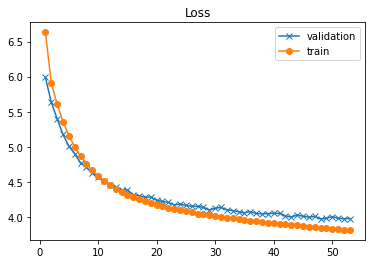

smallest val loss: (48, 3.9693544)
Current Lr:  0.0005905398

Time taken for this epoch: 26.02 secs

Epoch 54 Batch 0 Loss 3.6166
Epoch 54 Batch 150 Loss 3.7420
Epoch 54 Batch 300 Loss 3.7649
Epoch 54 Batch 450 Loss 3.7794
Epoch 54 Batch 600 Loss 3.7881
Epoch 54 Batch 750 Loss 3.8021

porsche offers <UNK> hotel in germany
kejriwal wishes modi on his th birthday
us <UNK> <UNK> <UNK> <UNK> <UNK> <UNK>
myanmar to get first <UNK> party in yrs

validation started ...

* Validation loss: 3.974343776702881 

* Train Loss 3.8047


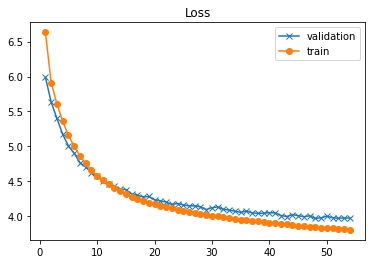

smallest val loss: (48, 3.9693544)
Current Lr:  0.00058470014

Time taken for this epoch: 25.60 secs

Epoch 55 Batch 0 Loss 3.5527
Epoch 55 Batch 150 Loss 3.7242
Epoch 55 Batch 300 Loss 3.7515
Epoch 55 Batch 450 Loss 3.7718
Epoch 55 Batch 600 Loss 3.7837
Epoch 55 Batch 750 Loss 3.7969

porsche has a hotel in germany
modi congratulates modi on his th bday modi on his th bday
us leader calls <UNK> <UNK> <UNK>
myanmar to be st <UNK> state of st time in yrs

validation started ...

* Validation loss: 3.969207763671875 

* Train Loss 3.7990


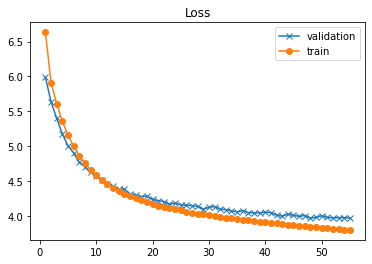

smallest val loss: (55, 3.9692078)
Current Lr:  0.00057891815

Time taken for this epoch: 25.72 secs

Epoch 56 Batch 0 Loss 3.8683
Epoch 56 Batch 150 Loss 3.7273
Epoch 56 Batch 300 Loss 3.7522
Epoch 56 Batch 450 Loss 3.7658
Epoch 56 Batch 600 Loss 3.7775
Epoch 56 Batch 750 Loss 3.7920

bmw opens <UNK> hotel in germany
modi wishes modi on his th birthday
trump <UNK> <UNK> <UNK> <UNK> <UNK>
myanmar to have first state of <UNK> prez

validation started ...

* Validation loss: 3.9584131240844727 

* Train Loss 3.7933


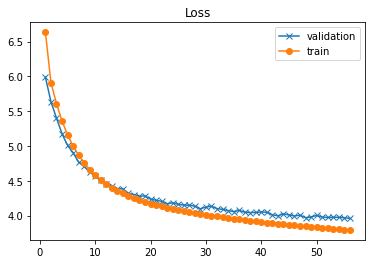

smallest val loss: (56, 3.9584131)
Current Lr:  0.00057319325

Time taken for this epoch: 25.33 secs

Epoch 57 Batch 0 Loss 3.6222
Epoch 57 Batch 150 Loss 3.7279
Epoch 57 Batch 300 Loss 3.7426
Epoch 57 Batch 450 Loss 3.7590
Epoch 57 Batch 600 Loss 3.7735
Epoch 57 Batch 750 Loss 3.7878

bmw <UNK> hotel is a hotel in germany
modi thanks modi for th birthday
us <UNK> <UNK> <UNK> <UNK> <UNK>
myanmar to be st <UNK> to be <UNK>

validation started ...

* Validation loss: 3.9651131629943848 

* Train Loss 3.7883


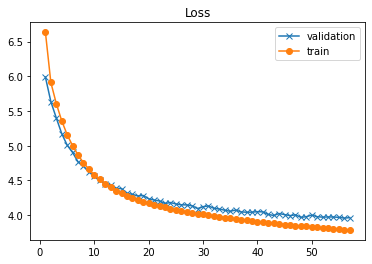

smallest val loss: (56, 3.9584131)
Current Lr:  0.00056752504

Time taken for this epoch: 25.46 secs

Epoch 58 Batch 0 Loss 3.7757
Epoch 58 Batch 150 Loss 3.7315
Epoch 58 Batch 300 Loss 3.7495
Epoch 58 Batch 450 Loss 3.7603
Epoch 58 Batch 600 Loss 3.7668
Epoch 58 Batch 750 Loss 3.7778

porsche offers <UNK> hotel in germany
modi thanks modi on modi on his th bday
trump <UNK> <UNK> <UNK> <UNK> <UNK>
myanmar to get first state party party

validation started ...

* Validation loss: 3.9591422080993652 

* Train Loss 3.7811


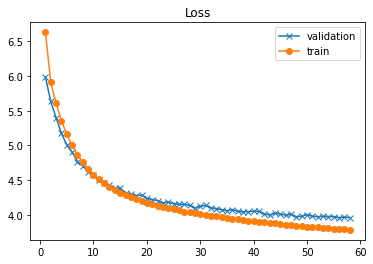

smallest val loss: (56, 3.9584131)
Current Lr:  0.0005619129

Time taken for this epoch: 25.01 secs

Epoch 59 Batch 0 Loss 3.7429
Epoch 59 Batch 150 Loss 3.7190
Epoch 59 Batch 300 Loss 3.7306
Epoch 59 Batch 450 Loss 3.7455
Epoch 59 Batch 600 Loss 3.7615
Epoch 59 Batch 750 Loss 3.7770

bmw offers <UNK> hotel in germany
modi thanks modi on his birthday
us <UNK> <UNK> <UNK> <UNK> <UNK> <UNK>
myanmar to be st <UNK> to be <UNK>

validation started ...

* Validation loss: 3.950485944747925 

* Train Loss 3.7773

Saving checkpoint for epoch 59 at checkpoints4/ckpt-14


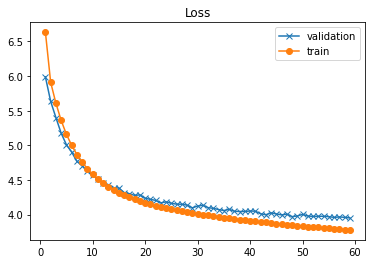

smallest val loss: (59, 3.950486)
Current Lr:  0.00055635616

Time taken for this epoch: 25.65 secs

Epoch 60 Batch 0 Loss 3.4330
Epoch 60 Batch 150 Loss 3.6889
Epoch 60 Batch 300 Loss 3.7203
Epoch 60 Batch 450 Loss 3.7345
Epoch 60 Batch 600 Loss 3.7543
Epoch 60 Batch 750 Loss 3.7659

bmw offers <UNK> hotel in germany
modi wishes modi on his birthday
un chief slams un over <UNK> <UNK>
myanmar to get first prez rule in yrs

validation started ...

* Validation loss: 3.9701731204986572 

* Train Loss 3.7701


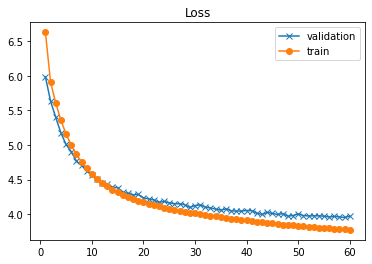

smallest val loss: (59, 3.950486)
Current Lr:  0.0005508545

Time taken for this epoch: 25.33 secs

Epoch 61 Batch 0 Loss 3.6544
Epoch 61 Batch 150 Loss 3.6954
Epoch 61 Batch 300 Loss 3.7210
Epoch 61 Batch 450 Loss 3.7406
Epoch 61 Batch 600 Loss 3.7510
Epoch 61 Batch 750 Loss 3.7668

audi offers <UNK> hotel in germany
modi wishes mamata on his th bday on his th bday
un chief slams trump over <UNK> <UNK>
myanmar to be first state of <UNK> state

validation started ...

* Validation loss: 3.9487149715423584 

* Train Loss 3.7686


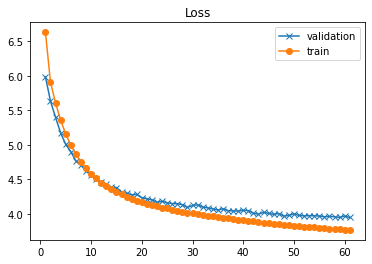

smallest val loss: (61, 3.948715)
Current Lr:  0.0005454071

Time taken for this epoch: 25.71 secs

Epoch 62 Batch 0 Loss 3.6200
Epoch 62 Batch 150 Loss 3.7198
Epoch 62 Batch 300 Loss 3.7261
Epoch 62 Batch 450 Loss 3.7391
Epoch 62 Batch 600 Loss 3.7501
Epoch 62 Batch 750 Loss 3.7635

bmw offers luxury hotel for cars
modi wishes modi on modi on his th birthday
trump calls for <UNK> <UNK> <UNK>
myanmar to get first state of first state of <UNK>

validation started ...

* Validation loss: 3.964798927307129 

* Train Loss 3.7631


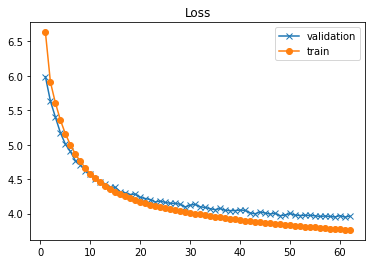

smallest val loss: (61, 3.948715)
Current Lr:  0.00054001366

Time taken for this epoch: 26.20 secs

Epoch 63 Batch 0 Loss 3.5498
Epoch 63 Batch 150 Loss 3.6979
Epoch 63 Batch 300 Loss 3.7130
Epoch 63 Batch 450 Loss 3.7276
Epoch 63 Batch 600 Loss 3.7407
Epoch 63 Batch 750 Loss 3.7515

porsche offers <UNK> hotel in germany
modi wishes mamata on his th birthday
trump <UNK> <UNK> <UNK> <UNK> <UNK>
myanmar to be st prez to be <UNK> prez

validation started ...

* Validation loss: 3.9395971298217773 

* Train Loss 3.7540


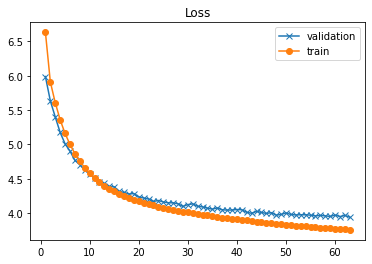

smallest val loss: (63, 3.9395971)
Current Lr:  0.0005346735

Time taken for this epoch: 25.50 secs

Epoch 64 Batch 0 Loss 3.6685
Epoch 64 Batch 150 Loss 3.6764
Epoch 64 Batch 300 Loss 3.7007
Epoch 64 Batch 450 Loss 3.7144
Epoch 64 Batch 600 Loss 3.7321
Epoch 64 Batch 750 Loss 3.7472

porsche offers <UNK> <UNK> <UNK>
modi thanks modi for birthday modi on his th birthday
trump is a <UNK> of <UNK> <UNK> <UNK>
myanmar to get first <UNK> state of <UNK>

validation started ...

* Validation loss: 3.9435982704162598 

* Train Loss 3.7493


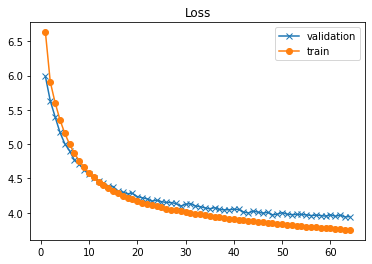

smallest val loss: (63, 3.9395971)
Current Lr:  0.0005293862

Time taken for this epoch: 25.82 secs

Epoch 65 Batch 0 Loss 3.6956
Epoch 65 Batch 150 Loss 3.6926
Epoch 65 Batch 300 Loss 3.7058
Epoch 65 Batch 450 Loss 3.7196
Epoch 65 Batch 600 Loss 3.7321
Epoch 65 Batch 750 Loss 3.7447

bmw offers luxury hotel in germany
modi thanks modi for th birthday
trump calls for <UNK> <UNK> <UNK>
myanmar to get first state party in yrs

validation started ...

* Validation loss: 3.9372498989105225 

* Train Loss 3.7460


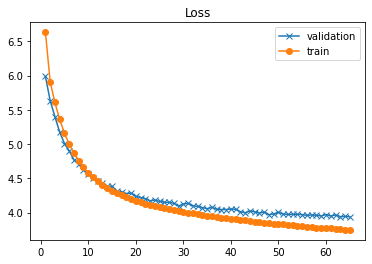

smallest val loss: (65, 3.93725)
Current Lr:  0.0005241512

Time taken for this epoch: 25.07 secs

Epoch 66 Batch 0 Loss 3.5682
Epoch 66 Batch 150 Loss 3.6784
Epoch 66 Batch 300 Loss 3.6970
Epoch 66 Batch 450 Loss 3.7078
Epoch 66 Batch 600 Loss 3.7224
Epoch 66 Batch 750 Loss 3.7378

audi has a hotel in germany
kejriwal thanks modi for th birthday
un chief <UNK> <UNK> <UNK> <UNK>
myanmar to be first state of first prez

validation started ...

* Validation loss: 3.9336814880371094 

* Train Loss 3.7386


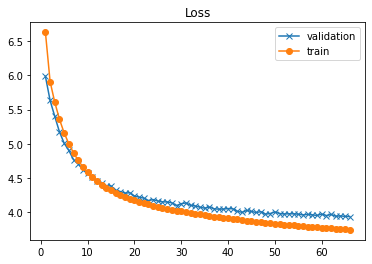

smallest val loss: (66, 3.9336815)
Current Lr:  0.000518968

Time taken for this epoch: 25.50 secs

Epoch 67 Batch 0 Loss 3.6015
Epoch 67 Batch 150 Loss 3.6644
Epoch 67 Batch 300 Loss 3.6895
Epoch 67 Batch 450 Loss 3.7120
Epoch 67 Batch 600 Loss 3.7208
Epoch 67 Batch 750 Loss 3.7320

bmw <UNK> hotel is a hotel in germany
modi wishes modi on his th bday on his th bday
un chief slams trump over <UNK> <UNK>
myanmar to get st <UNK> <UNK> for st time

validation started ...

* Validation loss: 3.9263625144958496 

* Train Loss 3.7342


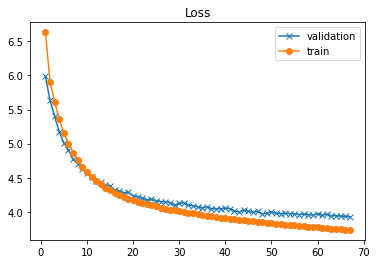

smallest val loss: (67, 3.9263625)
Current Lr:  0.0005138359

Time taken for this epoch: 26.46 secs

Epoch 68 Batch 0 Loss 3.6090
Epoch 68 Batch 150 Loss 3.6654
Epoch 68 Batch 300 Loss 3.6921
Epoch 68 Batch 450 Loss 3.7065
Epoch 68 Batch 600 Loss 3.7189
Epoch 68 Batch 750 Loss 3.7290

porsche offers luxury hotel in germany
modi thanks modi for birthday modi on his th birthday
<UNK> <UNK> <UNK> <UNK> <UNK> <UNK>
myanmar to get first <UNK> party in years

validation started ...

* Validation loss: 3.924238681793213 

* Train Loss 3.7297


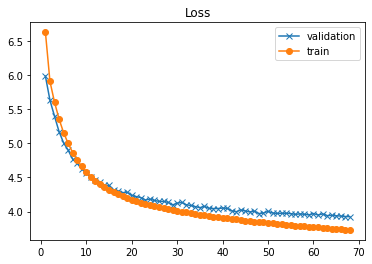

smallest val loss: (68, 3.9242387)
Current Lr:  0.0005087547

Time taken for this epoch: 25.83 secs

Epoch 69 Batch 0 Loss 3.7928
Epoch 69 Batch 150 Loss 3.6611
Epoch 69 Batch 300 Loss 3.6822
Epoch 69 Batch 450 Loss 3.6948
Epoch 69 Batch 600 Loss 3.7134
Epoch 69 Batch 750 Loss 3.7219

bmw offers cars to build cars in germany
kejriwal thanks modi for birthday
trump <UNK> <UNK> <UNK> <UNK> <UNK>
myanmar to be st prez to be <UNK> prez

validation started ...

* Validation loss: 3.9386701583862305 

* Train Loss 3.7243


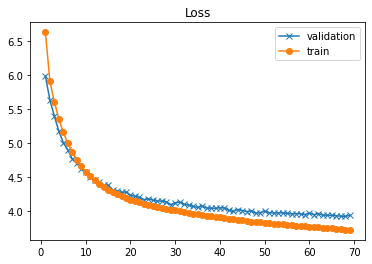

smallest val loss: (68, 3.9242387)
Current Lr:  0.00050372374

Time taken for this epoch: 25.37 secs

Epoch 70 Batch 0 Loss 3.6833
Epoch 70 Batch 150 Loss 3.6668
Epoch 70 Batch 300 Loss 3.6811
Epoch 70 Batch 450 Loss 3.6912
Epoch 70 Batch 600 Loss 3.7054
Epoch 70 Batch 750 Loss 3.7182

bmw offers <UNK> hotel in germany
modi wishes kejriwal on his th bday
un chief calls <UNK> <UNK> <UNK>
myanmar to introduce first state of <UNK>

validation started ...

* Validation loss: 3.9200665950775146 

* Train Loss 3.7213


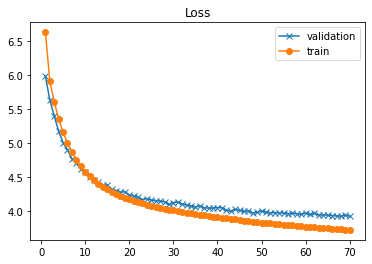

smallest val loss: (70, 3.9200666)
Current Lr:  0.0004987425

Time taken for this epoch: 25.10 secs

Epoch 71 Batch 0 Loss 3.5188
Epoch 71 Batch 150 Loss 3.6477
Epoch 71 Batch 300 Loss 3.6602
Epoch 71 Batch 450 Loss 3.6789
Epoch 71 Batch 600 Loss 3.6936
Epoch 71 Batch 750 Loss 3.7113

bmw offers luxury hotel in germany
modi thanks modi for birthday on his birthday
us chief slams trump over <UNK> <UNK>
myanmar to set up first state party

validation started ...

* Validation loss: 3.920644521713257 

* Train Loss 3.7138


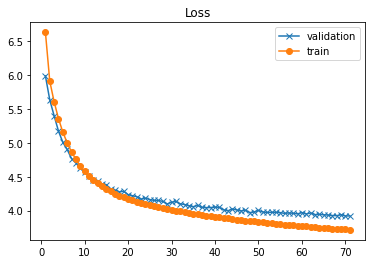

smallest val loss: (70, 3.9200666)
Current Lr:  0.0004938104

Time taken for this epoch: 25.74 secs

Epoch 72 Batch 0 Loss 3.5179
Epoch 72 Batch 150 Loss 3.6590
Epoch 72 Batch 300 Loss 3.6672
Epoch 72 Batch 450 Loss 3.6854
Epoch 72 Batch 600 Loss 3.6966
Epoch 72 Batch 750 Loss 3.7091

porsche offers luxury hotel in germany
kejriwal thanks pm for his th bday on his th bday
us chief calls of human rights group <UNK>
myanmar to get first <UNK> party

validation started ...

* Validation loss: 3.9354848861694336 

* Train Loss 3.7119


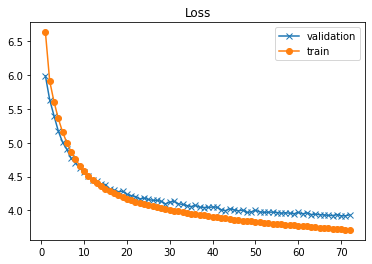

smallest val loss: (70, 3.9200666)
Current Lr:  0.0004889273

Time taken for this epoch: 25.67 secs

Epoch 73 Batch 0 Loss 3.8114
Epoch 73 Batch 150 Loss 3.6351
Epoch 73 Batch 300 Loss 3.6591
Epoch 73 Batch 450 Loss 3.6762
Epoch 73 Batch 600 Loss 3.6898
Epoch 73 Batch 750 Loss 3.7046

bmw offers <UNK> hotel in germany
modi thanks pm modi for his th birthday
trump calls <UNK> <UNK> <UNK> <UNK>
myanmar to be st <UNK> prez to be elected

validation started ...

* Validation loss: 3.911102533340454 

* Train Loss 3.7063


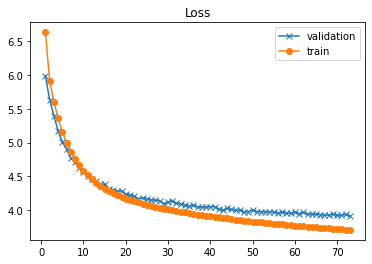

smallest val loss: (73, 3.9111025)
Current Lr:  0.00048409228

Time taken for this epoch: 25.24 secs

Epoch 74 Batch 0 Loss 3.8834
Epoch 74 Batch 150 Loss 3.6313
Epoch 74 Batch 300 Loss 3.6546
Epoch 74 Batch 450 Loss 3.6734
Epoch 74 Batch 600 Loss 3.6858
Epoch 74 Batch 750 Loss 3.6985

bmw offers <UNK> hotel in germany
modi wishes mamata on his th birthday
un chief <UNK> <UNK> <UNK> <UNK>
myanmar to get first <UNK> party

validation started ...

* Validation loss: 3.9140396118164062 

* Train Loss 3.7021


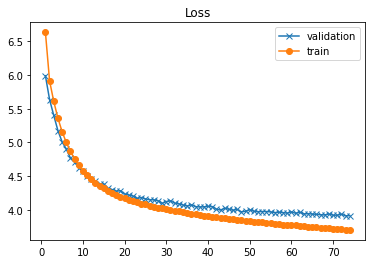

smallest val loss: (73, 3.9111025)
Current Lr:  0.00047930522

Time taken for this epoch: 24.99 secs

Epoch 75 Batch 0 Loss 3.6495
Epoch 75 Batch 150 Loss 3.6299
Epoch 75 Batch 300 Loss 3.6449
Epoch 75 Batch 450 Loss 3.6605
Epoch 75 Batch 600 Loss 3.6781
Epoch 75 Batch 750 Loss 3.6949

bmw offers <UNK> hotel in germany
modi thanks modi for modi on his th birthday
un leader calls for <UNK> <UNK> <UNK>
myanmar to get st <UNK> party party

validation started ...

* Validation loss: 3.911813497543335 

* Train Loss 3.6971


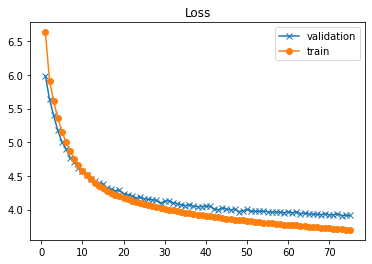

smallest val loss: (73, 3.9111025)
Current Lr:  0.00047456537

Time taken for this epoch: 25.49 secs

Epoch 76 Batch 0 Loss 3.6340
Epoch 76 Batch 150 Loss 3.6278
Epoch 76 Batch 300 Loss 3.6473
Epoch 76 Batch 450 Loss 3.6629
Epoch 76 Batch 600 Loss 3.6733
Epoch 76 Batch 750 Loss 3.6872

bmw offers luxury hotel in germany
modi wishes modi on his th bday birthday
trump <UNK> <UNK> <UNK> <UNK> <UNK>
myanmar to set up first <UNK> <UNK>

validation started ...

* Validation loss: 3.917097568511963 

* Train Loss 3.6892


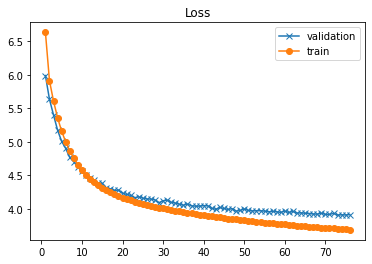

smallest val loss: (73, 3.9111025)
Current Lr:  0.00046987247

Time taken for this epoch: 25.22 secs

Epoch 77 Batch 0 Loss 3.4966
Epoch 77 Batch 150 Loss 3.6250
Epoch 77 Batch 300 Loss 3.6434
Epoch 77 Batch 450 Loss 3.6554
Epoch 77 Batch 600 Loss 3.6718
Epoch 77 Batch 750 Loss 3.6878

bmw offers luxury hotel in germany
modi thanks modi for th birthday
un chief <UNK> <UNK> <UNK> <UNK>
myanmar to get st state of st time in years

validation started ...

* Validation loss: 3.9060938358306885 

* Train Loss 3.6895


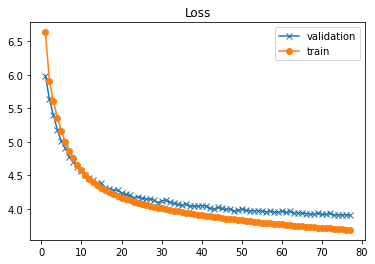

smallest val loss: (77, 3.9060938)
Current Lr:  0.000465226

Time taken for this epoch: 25.06 secs

Epoch 78 Batch 0 Loss 3.4733
Epoch 78 Batch 150 Loss 3.6169
Epoch 78 Batch 300 Loss 3.6338
Epoch 78 Batch 450 Loss 3.6521
Epoch 78 Batch 600 Loss 3.6644
Epoch 78 Batch 750 Loss 3.6808

bmw offers <UNK> hotel in germany
kejriwal thanks mamata for his th birthday
us <UNK> <UNK> <UNK> <UNK> trump
myanmar to be st state to be <UNK>

validation started ...

* Validation loss: 3.9069061279296875 

* Train Loss 3.6833


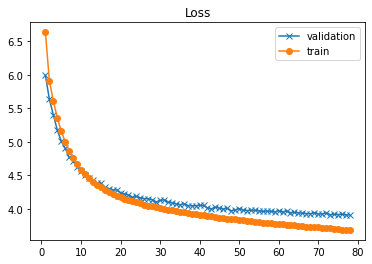

smallest val loss: (77, 3.9060938)
Current Lr:  0.0004606254

Time taken for this epoch: 25.45 secs

Epoch 79 Batch 0 Loss 3.6506
Epoch 79 Batch 150 Loss 3.6213
Epoch 79 Batch 300 Loss 3.6465
Epoch 79 Batch 450 Loss 3.6552
Epoch 79 Batch 600 Loss 3.6677
Epoch 79 Batch 750 Loss 3.6780

bmw offers luxury hotel to be built in germany
modi wishes modi on his birthday
trump <UNK> <UNK> <UNK> <UNK> trump
myanmar to get first state state party

validation started ...

* Validation loss: 3.9205543994903564 

* Train Loss 3.6816


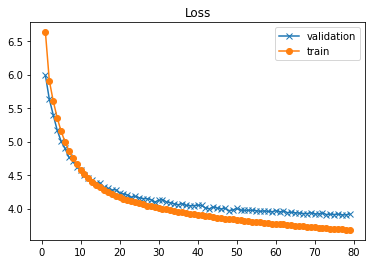

smallest val loss: (77, 3.9060938)
Current Lr:  0.00045607038

Time taken for this epoch: 25.44 secs

Epoch 80 Batch 0 Loss 3.6428
Epoch 80 Batch 150 Loss 3.6110
Epoch 80 Batch 300 Loss 3.6319
Epoch 80 Batch 450 Loss 3.6425
Epoch 80 Batch 600 Loss 3.6596
Epoch 80 Batch 750 Loss 3.6739

bmw offers luxury hotel in germany
kejriwal thanks modi for his th birthday
<UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK>
myanmar to get st <UNK> party in years

validation started ...

* Validation loss: 3.9177064895629883 

* Train Loss 3.6768


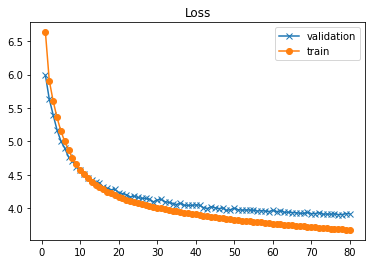

smallest val loss: (77, 3.9060938)
Current Lr:  0.0004515604

Time taken for this epoch: 24.96 secs

Epoch 81 Batch 0 Loss 3.7305
Epoch 81 Batch 150 Loss 3.6009
Epoch 81 Batch 300 Loss 3.6248
Epoch 81 Batch 450 Loss 3.6463
Epoch 81 Batch 600 Loss 3.6583
Epoch 81 Batch 750 Loss 3.6724

bmw offers luxury hotel for cars
kejriwal thanks mamata for modi on his th birthday
us <UNK> <UNK> <UNK> <UNK> trump
myanmar to get first prez <UNK> party

validation started ...

* Validation loss: 3.874419927597046 

* Train Loss 3.6744


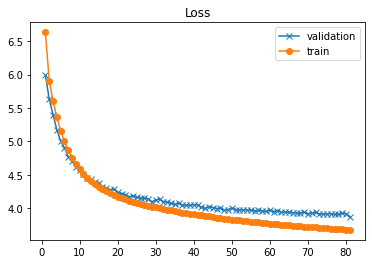

smallest val loss: (81, 3.87442)
Current Lr:  0.00044709494

Time taken for this epoch: 25.46 secs

Epoch 82 Batch 0 Loss 3.6959
Epoch 82 Batch 150 Loss 3.6009
Epoch 82 Batch 300 Loss 3.6303
Epoch 82 Batch 450 Loss 3.6472
Epoch 82 Batch 600 Loss 3.6548
Epoch 82 Batch 750 Loss 3.6691

bmw is a hotel in germany
modi wishes modi on his th bday birthday
trump calls for <UNK> <UNK> <UNK>
myanmar to be st state of <UNK> prez

validation started ...

* Validation loss: 3.9048385620117188 

* Train Loss 3.6689


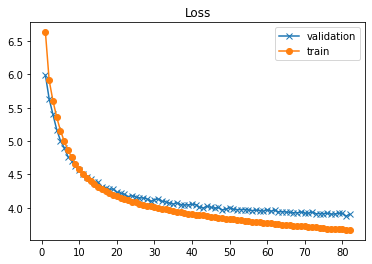

smallest val loss: (81, 3.87442)
Current Lr:  0.00044267369

Time taken for this epoch: 25.15 secs

Epoch 83 Batch 0 Loss 3.5022
Epoch 83 Batch 150 Loss 3.5998
Epoch 83 Batch 300 Loss 3.6278
Epoch 83 Batch 450 Loss 3.6404
Epoch 83 Batch 600 Loss 3.6495
Epoch 83 Batch 750 Loss 3.6638

bmw offers luxury hotel to build cars
kejriwal thanks modi for th bday on his th bday
us <UNK> <UNK> <UNK> <UNK> trump
myanmar to get first state of first prez

validation started ...

* Validation loss: 3.9014410972595215 

* Train Loss 3.6651


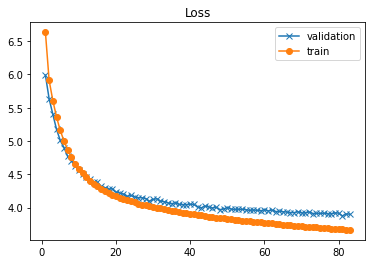

smallest val loss: (81, 3.87442)
Current Lr:  0.00043829618

Time taken for this epoch: 25.43 secs

Epoch 84 Batch 0 Loss 3.6345
Epoch 84 Batch 150 Loss 3.6018
Epoch 84 Batch 300 Loss 3.6211
Epoch 84 Batch 450 Loss 3.6333
Epoch 84 Batch 600 Loss 3.6486
Epoch 84 Batch 750 Loss 3.6604

bmw offers luxury hotel to be built in germany
modi thanks mamata for his th bday
us <UNK> <UNK> <UNK> <UNK> <UNK> un chief
myanmar to be st prez to be <UNK> prez

validation started ...

* Validation loss: 3.892385244369507 

* Train Loss 3.6608


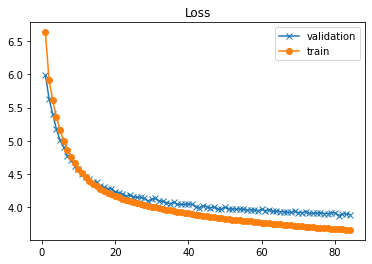

smallest val loss: (81, 3.87442)
Current Lr:  0.00043396192

Time taken for this epoch: 25.53 secs

Epoch 85 Batch 0 Loss 3.4500
Epoch 85 Batch 150 Loss 3.5923
Epoch 85 Batch 300 Loss 3.6169
Epoch 85 Batch 450 Loss 3.6245
Epoch 85 Batch 600 Loss 3.6419
Epoch 85 Batch 750 Loss 3.6552

bmw offers luxury hotel in germany
kejriwal thanks modi on his birthday
trump calls for <UNK> <UNK> of <UNK>
myanmar to get first state of st time in years

validation started ...

* Validation loss: 3.922013759613037 

* Train Loss 3.6562


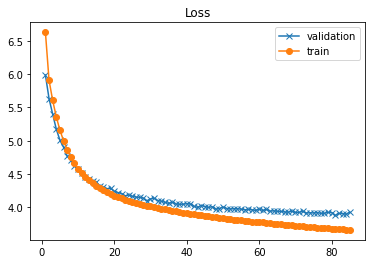

smallest val loss: (81, 3.87442)
Current Lr:  0.0004296705

Time taken for this epoch: 25.47 secs

Epoch 86 Batch 0 Loss 3.8240
Epoch 86 Batch 150 Loss 3.5847
Epoch 86 Batch 300 Loss 3.6041
Epoch 86 Batch 450 Loss 3.6197
Epoch 86 Batch 600 Loss 3.6386
Epoch 86 Batch 750 Loss 3.6501

porsche offers hotel <UNK> hotel in germany
kejriwal thanks modi for modi on his th birthday
us <UNK> <UNK> <UNK> <UNK> <UNK> <UNK>
myanmar to get first <UNK> state of <UNK>

validation started ...

* Validation loss: 3.9056761264801025 

* Train Loss 3.6526


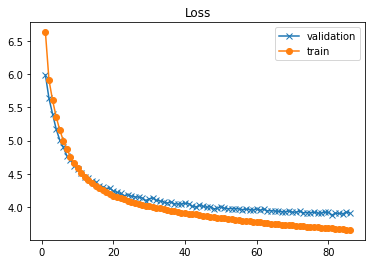

smallest val loss: (81, 3.87442)
Current Lr:  0.00042542157

Time taken for this epoch: 25.35 secs

Epoch 87 Batch 0 Loss 3.5553
Epoch 87 Batch 150 Loss 3.5997
Epoch 87 Batch 300 Loss 3.6127
Epoch 87 Batch 450 Loss 3.6236
Epoch 87 Batch 600 Loss 3.6316
Epoch 87 Batch 750 Loss 3.6470

bmw offers cars to build cars in germany
modi thanks mamata for his th birthday
us <UNK> <UNK> <UNK> <UNK> trump
myanmar to be st prez to be first prez of state of

validation started ...

* Validation loss: 3.900151014328003 

* Train Loss 3.6483


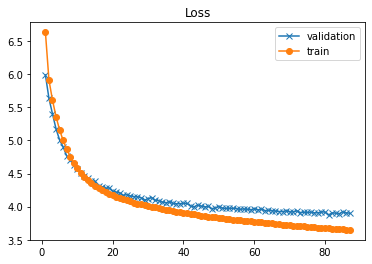

smallest val loss: (81, 3.87442)
Current Lr:  0.0004212146

Time taken for this epoch: 25.86 secs

Epoch 88 Batch 0 Loss 3.6701
Epoch 88 Batch 150 Loss 3.5702
Epoch 88 Batch 300 Loss 3.5898
Epoch 88 Batch 450 Loss 3.6108
Epoch 88 Batch 600 Loss 3.6244
Epoch 88 Batch 750 Loss 3.6414

bmw offers cars to build cars
modi thanks modi for birthday on his birthday
us <UNK> <UNK> <UNK> <UNK> <UNK> <UNK>
myanmar to get its first state party

validation started ...

* Validation loss: 3.890676975250244 

* Train Loss 3.6443


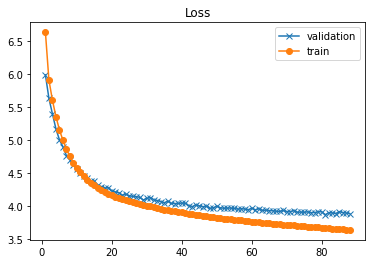

smallest val loss: (81, 3.87442)
Current Lr:  0.00041704928

Time taken for this epoch: 25.13 secs

Epoch 89 Batch 0 Loss 3.7339
Epoch 89 Batch 150 Loss 3.5860
Epoch 89 Batch 300 Loss 3.6067
Epoch 89 Batch 450 Loss 3.6140
Epoch 89 Batch 600 Loss 3.6235
Epoch 89 Batch 750 Loss 3.6379

bmw offers cars to build cars
kejriwal thanks modi on his th bday birthday
trump is a <UNK> of <UNK> <UNK> un chief
myanmar to get first state of <UNK> state

validation started ...

* Validation loss: 3.889875888824463 

* Train Loss 3.6404


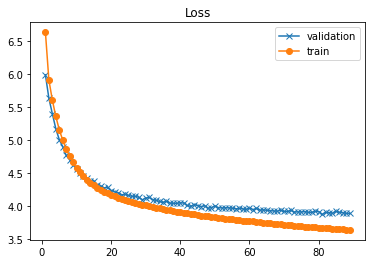

smallest val loss: (81, 3.87442)
Current Lr:  0.00041292518

Time taken for this epoch: 25.49 secs

Epoch 90 Batch 0 Loss 3.4672
Epoch 90 Batch 150 Loss 3.5504
Epoch 90 Batch 300 Loss 3.5862
Epoch 90 Batch 450 Loss 3.6034
Epoch 90 Batch 600 Loss 3.6177
Epoch 90 Batch 750 Loss 3.6358

bmw offers cars to build cars in germany
modi thanks modi for th bday on his th bday
un chief calls trump <UNK> <UNK>
myanmar to be st <UNK> state party

validation started ...

* Validation loss: 3.909679412841797 

* Train Loss 3.6383


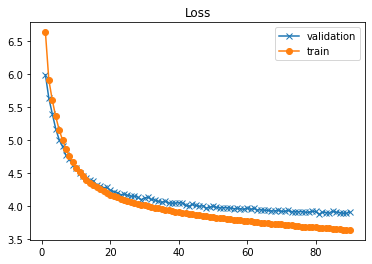

smallest val loss: (81, 3.87442)
Current Lr:  0.0004088418

Time taken for this epoch: 25.73 secs

Epoch 91 Batch 0 Loss 3.6850
Epoch 91 Batch 150 Loss 3.5692
Epoch 91 Batch 300 Loss 3.5886
Epoch 91 Batch 450 Loss 3.6084
Epoch 91 Batch 600 Loss 3.6190
Epoch 91 Batch 750 Loss 3.6313

bmw offers luxury hotel in germany
modi wishes modi on his th bday on his bday
us <UNK> <UNK> <UNK> <UNK> <UNK> <UNK>
myanmar to get first state state party

validation started ...

* Validation loss: 3.8827314376831055 

* Train Loss 3.6330


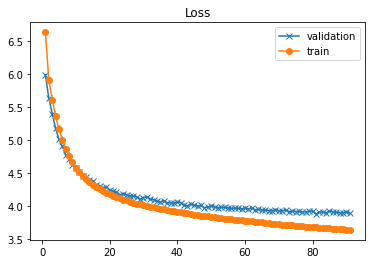

smallest val loss: (81, 3.87442)
Current Lr:  0.00040479883

Time taken for this epoch: 25.34 secs

Epoch 92 Batch 0 Loss 3.5177
Epoch 92 Batch 150 Loss 3.5724
Epoch 92 Batch 300 Loss 3.5918
Epoch 92 Batch 450 Loss 3.6060
Epoch 92 Batch 600 Loss 3.6147
Epoch 92 Batch 750 Loss 3.6302

bmw offers luxury hotel in germany
kejriwal thanks modi on his birthday
us <UNK> <UNK> <UNK> <UNK> <UNK>
myanmar to get first state party in years

validation started ...

* Validation loss: 3.888838052749634 

* Train Loss 3.6316


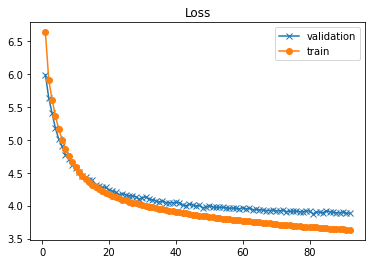

smallest val loss: (81, 3.87442)
Current Lr:  0.00040079583

Time taken for this epoch: 24.96 secs

Epoch 93 Batch 0 Loss 3.5333
Epoch 93 Batch 150 Loss 3.5711
Epoch 93 Batch 300 Loss 3.5941
Epoch 93 Batch 450 Loss 3.6001
Epoch 93 Batch 600 Loss 3.6115
Epoch 93 Batch 750 Loss 3.6248

bmw <UNK> hotel is a hotel in germany
kejriwal wishes modi on his th birthday
trump calls for <UNK> <UNK> of <UNK>
myanmar to get first state party for st time in years

validation started ...

* Validation loss: 3.8883461952209473 

* Train Loss 3.6267


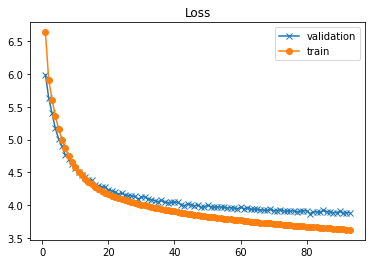

smallest val loss: (81, 3.87442)
Current Lr:  0.00039683245

Time taken for this epoch: 25.82 secs

Epoch 94 Batch 0 Loss 3.3772
Epoch 94 Batch 150 Loss 3.5588
Epoch 94 Batch 300 Loss 3.5776
Epoch 94 Batch 450 Loss 3.5928
Epoch 94 Batch 600 Loss 3.6087
Epoch 94 Batch 750 Loss 3.6239

porsche offers luxury hotel for cars
modi wishes modi on his th birthday
trump calls for <UNK> <UNK> <UNK>
myanmar to get first state party in yrs

validation started ...

* Validation loss: 3.896791934967041 

* Train Loss 3.6260


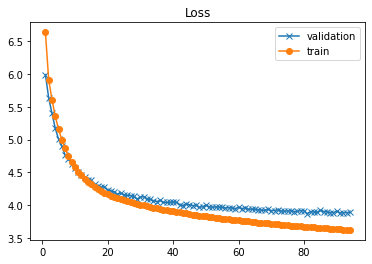

smallest val loss: (81, 3.87442)
Current Lr:  0.00039290817

Time taken for this epoch: 25.05 secs

Epoch 95 Batch 0 Loss 3.6568
Epoch 95 Batch 150 Loss 3.5540
Epoch 95 Batch 300 Loss 3.5758
Epoch 95 Batch 450 Loss 3.5912
Epoch 95 Batch 600 Loss 3.6054
Epoch 95 Batch 750 Loss 3.6174

bmw offers luxury hotel in germany
kejriwal thanks modi for bday birthday
trump is <UNK> <UNK> of human rights <UNK> chief
myanmar to be st prez to be first prez of state

validation started ...

* Validation loss: 3.9070966243743896 

* Train Loss 3.6190


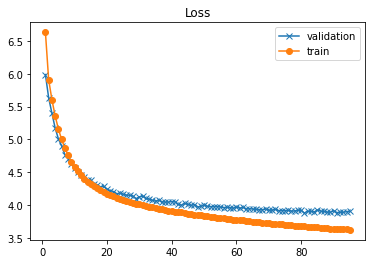

smallest val loss: (81, 3.87442)
Current Lr:  0.00038902278

Time taken for this epoch: 25.62 secs

Epoch 96 Batch 0 Loss 3.2718
Epoch 96 Batch 150 Loss 3.5584
Epoch 96 Batch 300 Loss 3.5763
Epoch 96 Batch 450 Loss 3.5868
Epoch 96 Batch 600 Loss 3.5986
Epoch 96 Batch 750 Loss 3.6136

porsche offers luxury hotel to build luxury hotel
modi thanks modi on his th bday
us <UNK> is a <UNK> <UNK> <UNK>
myanmar to get st <UNK> state of state

validation started ...

* Validation loss: 3.871727228164673 

* Train Loss 3.6167


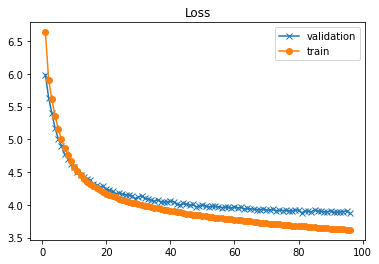

smallest val loss: (96, 3.8717272)
Current Lr:  0.00038517575

Time taken for this epoch: 25.21 secs

Epoch 97 Batch 0 Loss 3.5320
Epoch 97 Batch 150 Loss 3.5475
Epoch 97 Batch 300 Loss 3.5635
Epoch 97 Batch 450 Loss 3.5836
Epoch 97 Batch 600 Loss 3.5940
Epoch 97 Batch 750 Loss 3.6094

bmw offers luxury hotel in germany
kejriwal wishes modi on his th birthday
us chief <UNK> <UNK> of <UNK> <UNK>
myanmar to get first <UNK> state party

validation started ...

* Validation loss: 3.878101348876953 

* Train Loss 3.6128


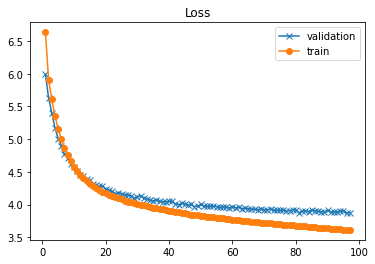

smallest val loss: (96, 3.8717272)
Current Lr:  0.00038136684

Time taken for this epoch: 28.73 secs

Epoch 98 Batch 0 Loss 3.4580
Epoch 98 Batch 150 Loss 3.5776
Epoch 98 Batch 300 Loss 3.5775
Epoch 98 Batch 450 Loss 3.5912
Epoch 98 Batch 600 Loss 3.6030
Epoch 98 Batch 750 Loss 3.6097

bmw offers luxury hotel to build cars
kejriwal thanks pm for his th birthday
us <UNK> <UNK> <UNK> <UNK> <UNK>
myanmar to be first state of first president

validation started ...

* Validation loss: 3.885477304458618 

* Train Loss 3.6118


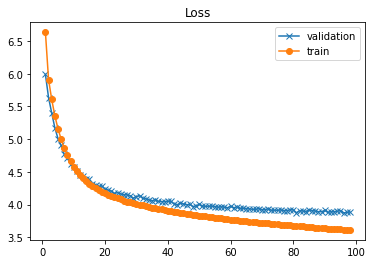

smallest val loss: (96, 3.8717272)
Current Lr:  0.00037759557

Time taken for this epoch: 25.18 secs

Epoch 99 Batch 0 Loss 3.5709
Epoch 99 Batch 150 Loss 3.5519
Epoch 99 Batch 300 Loss 3.5603
Epoch 99 Batch 450 Loss 3.5747
Epoch 99 Batch 600 Loss 3.5879
Epoch 99 Batch 750 Loss 3.6041

porsche offers luxury hotel in germany
kejriwal thanks mamata for his th birthday
<UNK> is a <UNK> of human rights un chief
myanmar to have st presidents party

validation started ...

* Validation loss: 3.875734806060791 

* Train Loss 3.6056


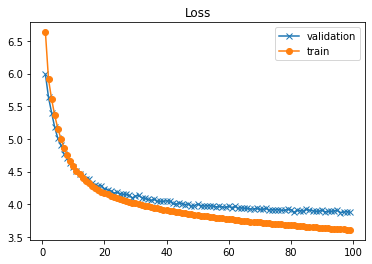

smallest val loss: (96, 3.8717272)
Current Lr:  0.0003738616

Time taken for this epoch: 25.08 secs

Epoch 100 Batch 0 Loss 3.4230
Epoch 100 Batch 150 Loss 3.5513
Epoch 100 Batch 300 Loss 3.5657
Epoch 100 Batch 450 Loss 3.5749
Epoch 100 Batch 600 Loss 3.5860
Epoch 100 Batch 750 Loss 3.6006

bmw offers luxury hotel in germany
modi wishes modi on his th birthday
trump <UNK> <UNK> <UNK> of <UNK> of <UNK>
myanmar to get first <UNK> party in years

validation started ...

* Validation loss: 3.892671823501587 

* Train Loss 3.6039


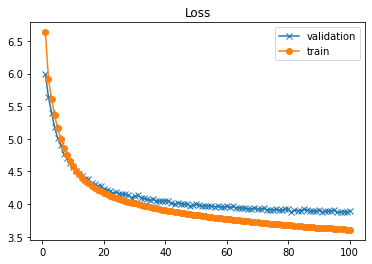

smallest val loss: (96, 3.8717272)
Current Lr:  0.00037016446

Time taken for this epoch: 25.17 secs



In [110]:
#printing all the parameters for reference
print(params)
print('#'*40)

for epoch in range(ep,EPOCHS+1):
  #defining the epochs and time
    ep = epoch
    start = time.time()

    train_loss.reset_states()
  
    for (batch, (inp, tar)) in enumerate(dataset):
        #training the modelk
        train_step(inp, tar)
    
        if batch % 150 == 0:
            print ('Epoch {} Batch {} Loss {:.4f}'.format(epoch , batch, train_loss.result()))

    #displaying few words that are summarized to notice differences between two epoch outputs              
    print()
    print(summarize(clean_words(longreview_val['long'][i1])))
    print(summarize(clean_words(longreview_val['long'][i2])))
    print(summarize(clean_words(longreview_val['long'][i3])))
    print(summarize(clean_words(longreview_val['long'][i4])))
    print()
    
    #computing validation loss
    val_loss_ = validate().numpy()
    #appending the validation loss in order to plot graphs later
    history['val'].append((epoch,val_loss_))
    print ('\n* Train Loss {:.4f}'.format(train_loss.result()))
    history['train'].append((epoch,train_loss.result().numpy()))
    
    #saving the results into checkpoint manager
    if best_val_loss-val_loss_ > 0.1:
        ckpt_save_path4 = ckpt_manager4.save()
        print ('\nSaving checkpoint for epoch {} at {}'.format(epoch, ckpt_save_path4))  
        best_val_loss = val_loss_
    
    #printing the loss as well as the validations
    hist(history)
    print('Current Lr: ',optimizer2._decayed_lr('float32').numpy())
    print ('\nTime taken for this epoch: {:.2f} secs\n'.format(time.time() - start))
    print('='*40)

output removed to reduce file size for github

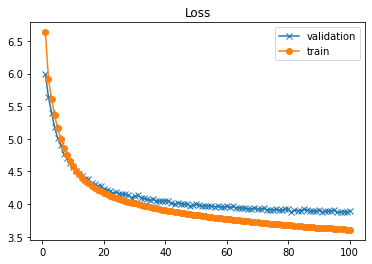

smallest val loss: (96, 3.8717272)


{'d_model': 50,
 'd_out_rate': 0.1,
 'dff': 512,
 'init_lr': 0.001,
 'lmbda_l2': 0.1,
 'num_heads': 5,
 'num_layers': 4}

In [111]:
hist(history)
params

you can use more data or more regularization to avoid the overfitting 

In [116]:
#testing the model over a review
print(clean_words(longreview_val['long'][i1]))
print()
#printing out the model's output or the summary of the review
print(summarize(clean_words(longreview_val['long'][i1])))

the v hotel in boblingen germany is an automobileinspired hotel that offers its guests different carthemed rooms with beds designed to look like cars the hotel offers a mercedes suite and other rooms modelled after a gas station a workshop and a drivein cinema the hotel additionally provides a porsche and mercedes museum tour

bmw offers luxury hotel in germany


In [117]:
#testing the model over a review
print(clean_words(longreview_val['long'][i4]))
print()
#printing out the model's output or the summary of the review
print(summarize(clean_words(longreview_val['long'][i4])))

the parliamentary session that will install myanmars first democratically elected government in over  years began on monday with majority members from prodemocracy leader aung san suu kyis party suu kyis national league for democracy won  of the total elected seats in the elections suu kyi is constitutionally barred from presidency but has vowed to rule through a proxy

myanmar to get first <UNK> party in years


##Conclusion:

The final training model parameters are epochs= 100, batch size = 64, dropout rate = 0.1. The output that I received using this model was not accurate and would expect a better summary. Maybe the dataset is small for this application and considering larger dataset can improve results. The model might be overfitting and hence we are receiving output which is giving us the Out of Vocab token in summaries. The loss function comparison between the 1st epoch results and the 100th epoch results is better. It took 40mins to run the complete model, maybe increasing more epoch and reducing the batch size can improve the model more. Without using GPU, it took around 10mins to complete just 1 epoch. Label smoothing, a regularization technique that introduces noise in the dataset suggesting that there might be some mistakes so that the model won’t result in overfitting. We can perform Label smoothing over this dataset, also use ROGUE metrics to better display the metrics such as the accuracy of the model etc. In this project the person has trained a model from scratch defining all the encoder, decoder layers. Maybe a pretrained model can improve the results and provide better summaries. Also fine tuning the parameters and trying different combinations of batch size as well as epochs can improve results but there are many hardware limitations. 

References:


1.   https://www.kaggle.com/code/hamishdickson/using-keras-oov-tokens/notebook
2.   https://paperswithcode.com/method/scaled
3.   https://paperswithcode.com/method/multi-head-attention
4.   https://kazemnejad.com/blog/transformer_architecture_positional_encoding/
5.   https://www.tensorflow.org/guide/keras/masking_and_padding
6.   https://blogs.nvidia.com/blog/2022/03/25/what-is-a-transformer-model/#:~:text=A%20transformer%20model%20is%20a,25%2C%202022%20by%20Rick%20Merritt
7.   https://github.com/Moeinh77/Transformer-networks-for-abstractive-summarization/blob/master/main-github.ipynb









